In [2]:
import psycopg2
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Database connection parameters
DB_NAME = "airline_delay_analysis"
DB_USER = "postgres"
DB_PASSWORD = "root"
DB_HOST = "localhost"
DB_PORT = "5432" 

## Question 1: Which airports have the highest average delay rates?

<Figure size 1200x600 with 0 Axes>

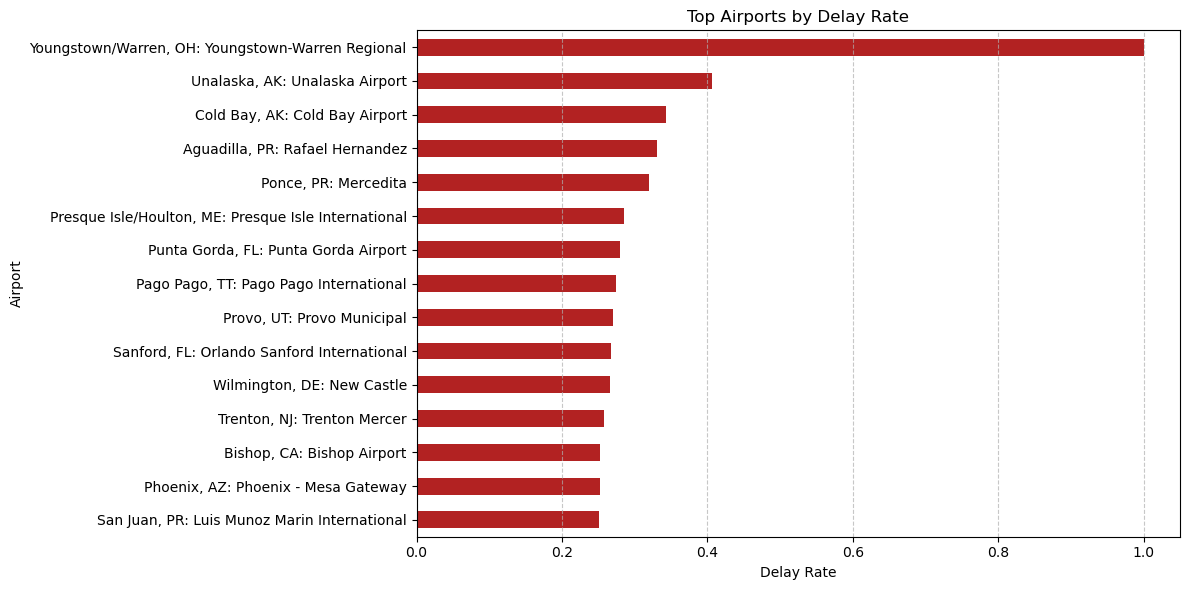

In [5]:
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
from IPython.display import display

# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Execute SQL query to get airport delay rates
query = """
    SELECT 
        a.airport, 
        a.airport_name, 
        SUM(f.arr_del15) AS total_delays, 
        SUM(f.arr_flights) AS total_flights, 
        ROUND(CAST(SUM(f.arr_del15) * 1.0 / NULLIF(SUM(f.arr_flights), 0) AS NUMERIC), 4) AS delay_rate
    FROM flight_delays_fact f
    JOIN airports_dimension a ON f.airport_key = a.airport_key
    GROUP BY a.airport, a.airport_name
    ORDER BY delay_rate DESC
    LIMIT 15;
"""
df_airport_delays = pd.read_sql(query, conn)
conn.close()

# Visualization: Bar Chart for Delay Rate by Airport
plt.figure(figsize=(12, 6))
df_airport_delays.sort_values('delay_rate', ascending=True).plot(
    kind='barh', x='airport_name', y='delay_rate', color='firebrick', legend=False, figsize=(12, 6)
)
plt.xlabel("Delay Rate")
plt.ylabel("Airport")
plt.title("Top Airports by Delay Rate")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The **bar chart visualizes the delay rate** at the top 15 most delayed airports.
- **Youngstown (YNG)** exhibit **extremely high delay rates**.
- The delay rate of other top airports are almost **under 40%**.

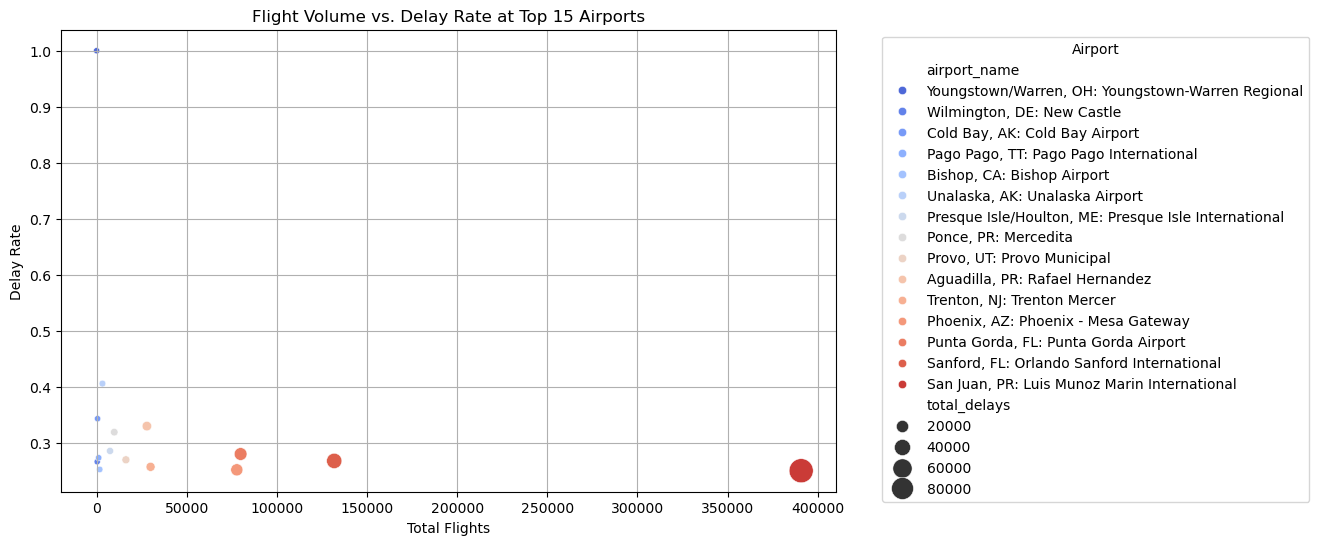

In [7]:
import seaborn as sns

conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# SQL Query
query = """
    SELECT 
        a.airport, 
        a.airport_name, 
        SUM(f.arr_flights) AS total_flights, 
        SUM(f.arr_del15) AS total_delays, 
        ROUND(CAST(SUM(f.arr_del15) * 1.0 / NULLIF(SUM(f.arr_flights), 0) AS NUMERIC), 4) AS delay_rate
    FROM flight_delays_fact f
    JOIN airports_dimension a ON f.airport_key = a.airport_key
    WHERE a.airport IN ('YNG', 'DUT', 'CDB', 'BQN', 'PSE', 'PQI', 'PGD', 'PPG', 
                        'PVU', 'SFB', 'ILG', 'TTN', 'BIH', 'AZA', 'SJU')
    GROUP BY a.airport, a.airport_name
    ORDER BY total_flights ASC;
"""

# Execute SQL query using SQLAlchemy
df_flight_volume = pd.read_sql(query, conn)
conn.close()

# Create scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_flight_volume, x="total_flights", y="delay_rate", 
                hue="airport_name", size="total_delays", sizes=(20, 300), palette="coolwarm")

plt.xlabel("Total Flights")
plt.ylabel("Delay Rate")
plt.title("Flight Volume vs. Delay Rate at Top 15 Airports")
plt.legend(title="Airport", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

1. **Small Airports Have Extreme Delay Rates**
    - Airports with very few total flights (left side of the x-axis) tend to have higher delay rates.
	- Example: Youngstown/Warren (OH) shows an extremely high delay rate (~100%) but very few flights in total.


2. **Medium-Sized Airports Have More Balanced Delay Rates**
	- Airports with moderate traffic (~50,000 - 150,000 flights) tend to have delay rates in the 25%-30% range.
	- This suggests that moderate-traffic airports experience congestion but may have better management than very small airports.


3. **High-Traffic Airports Have Lower Delay Rates (but High Total Delays)**
	- Large airports (*San Juan, PR*) have relatively lower delay rates (~25%), but the total number of delayed flights is high.

## Question 2: What are the causes of delays at these airports with high delay rate?

In [10]:
# Load airport geographic coordinates for mapping
airport_locations = pd.read_csv("https://davidmegginson.github.io/ourairports-data/airports.csv")
airport_locations = airport_locations[['iata_code', 'latitude_deg', 'longitude_deg']]
airport_locations.columns = ['airport', 'lat', 'lon']

# Merge delay rate data with location data
df_airport_delays = df_airport_delays.merge(airport_locations, on='airport', how='left').dropna()

# Visualization: Create a Bubble Map of High-Delay Airports
# Create map centered on the US
m = folium.Map(location=[39.8283, -98.5795], zoom_start=4)
marker_cluster = MarkerCluster().add_to(m)

# Add airport markers
for _, row in df_airport_delays.dropna(subset=['lat', 'lon']).iterrows():
    folium.CircleMarker(
        location=[row["lat"], row["lon"]],
        radius=row["delay_rate"] * 100,  # Adjust size based on delay rate
        color="red" if row["delay_rate"] > 0.2 else "orange",
        fill=True,
        fill_color="red" if row["delay_rate"] > 0.2 else "orange",
        fill_opacity=0.6,
        popup=f"{row['airport']}:{row['airport_name']}: {row['delay_rate']:.2%}",
    ).add_to(marker_cluster)

# Show the map
display(m)

- From this map, we can see that almost **40%** of the airports with high delay rates are not in the Continental United States. They are in Alaska, Puerto Rico and Samoa. The reason for their delays is probably the unpredictable local **weather conditions** (tropical climate and extreme cold climate) and relatively **backward air traffic control**.
- The areas with high delay rates in the Continental United States are concentrated around **New York**, **Florida**, **three small airports in the west**: PVU (Provo, UT), BIH (Bishop, CA), and AZA (Phoenix, AZ), as well as a small airport (PQI-Presque Isle, ME) **near Canada**.

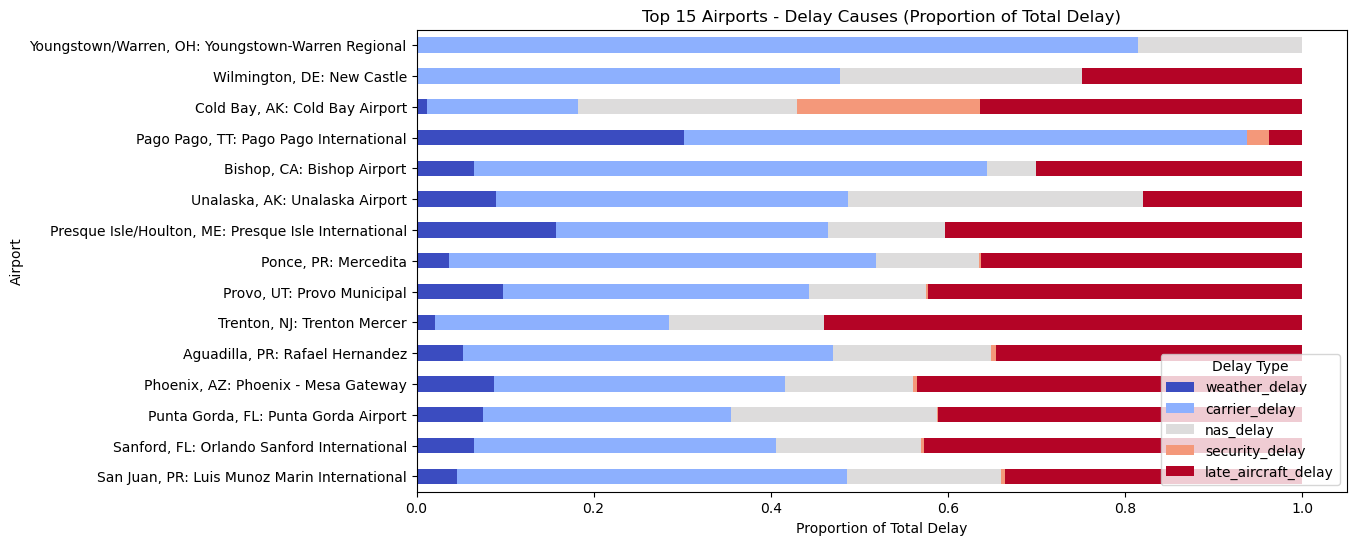

In [12]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Execute SQL query
query = """
    SELECT 
        a.airport, 
        a.airport_name, 
        SUM(f.weather_delay) AS weather_delay, 
        SUM(f.carrier_delay) AS carrier_delay, 
        SUM(f.nas_delay) AS nas_delay, 
        SUM(f.security_delay) AS security_delay, 
        SUM(f.late_aircraft_delay) AS late_aircraft_delay, 
        SUM(f.weather_delay + f.carrier_delay + f.nas_delay + f.security_delay + f.late_aircraft_delay) AS total_delay
    FROM flight_delays_fact f
    JOIN airports_dimension a ON f.airport_key = a.airport_key
    WHERE a.airport IN ('YNG', 'DUT', 'CDB', 'BQN', 'PSE', 'PQI', 'PGD', 'PPG', 
                        'PVU', 'SFB', 'ILG', 'TTN', 'BIH', 'AZA', 'SJU')
    GROUP BY a.airport, a.airport_name
    ORDER BY total_delay DESC;
"""
df_delay_reasons = pd.read_sql(query, conn)
conn.close()

# Normalize by total delay to get percentages
delay_types = ["weather_delay", "carrier_delay", "nas_delay", "security_delay", "late_aircraft_delay"]
df_delay_reasons[delay_types] = df_delay_reasons[delay_types].div(df_delay_reasons["total_delay"], axis=0)

# Set index for plotting
df_delay_reasons.set_index("airport_name", inplace=True)

# Create stacked bar chart
df_delay_reasons[delay_types].plot(kind="barh", stacked=True, figsize=(12, 6), colormap="coolwarm")

plt.xlabel("Proportion of Total Delay")
plt.ylabel("Airport")
plt.title("Top 15 Airports - Delay Causes (Proportion of Total Delay)")
plt.legend(title="Delay Type")
plt.show()

1. **Late Aircraft Delays and Carrier Delays Are the Dominant Causes of Delays**
	- Late aircraft delays (dark red) and carrier delays (light blue) together account for the majority of delays at most airports.
	- Airports where **Late Aircraft Delays dominate**:
    	- Punta Gorda (PGD), Trenton (TTN), Presque Isle (PQI), Cold Bay (CDB), Orlando Sanford (SFB)
    	- These airports likely operate with **tightly packed schedules**, meaning delays in incoming flights create a ripple effect on outbound flights.
	- Airports where **Carrier Delays dominate**:
    	- Youngstown (YNG), Pago Pago(PPG), Bishop (BIH), Wilmington (ILG), Ponce (PSE)
    	- These airports are **Low-Cost Carrier Hubs** or **Remote & Seasonal airports**, it’s likely that fewer available aircraft and crews contribute to longer delays.
2. **Weather Delays Are Significant for Certain Airports**
    - Pago Pago (PPG), Presque Isle (PQI), and Unalaska (DUT) experience the highest proportions of weather-related delays.
	- These airports are either **island airports**, **northern airports**, or located in regions with **frequent storms**, meaning they are more vulnerable to seasonal weather disruptions.
3. **NAS Delays (National Air System) Are Relevant for Specific Airports**
	- Unalaska (DUT), Wilmington (ILG), and Cold Bay (CDB) have a higher proportion of NAS delays.
	- These airports are close to **major air corridors** or with **limited runway capacity**.
4. **Security Delays Are Negligible**
	- Security delays (orange) make up a **very small proportion** of total delays across all airports.
	- Cold Bay (CBD) has a slightly higher percentage of security delays, possibly due to its location and additional security screening for international flights.

## Question 3: How do flight cancellations impact airport delay rates? Are certain airports more prone to cancellations instead of delays?

<Figure size 1200x600 with 0 Axes>

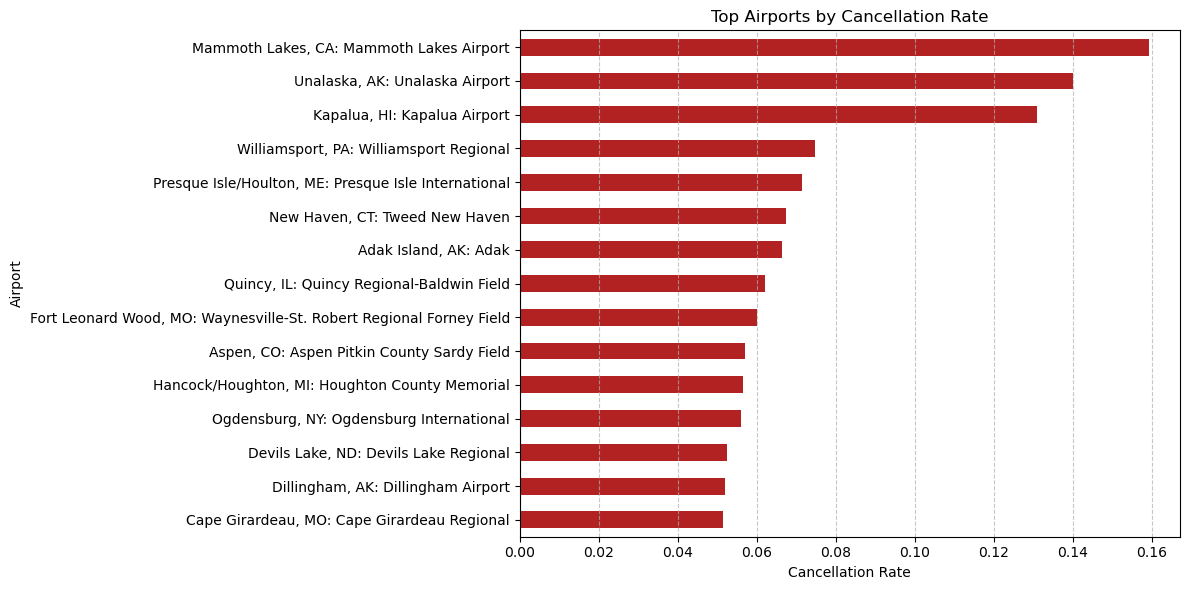

In [15]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Execute SQL query to get airport delay rates
query = """
    SELECT 
        a.airport, 
        a.airport_name, 
        SUM(f.arr_flights) AS total_flights, 
        SUM(f.arr_cancelled) AS total_cancelled, 
        ROUND(CAST(SUM(f.arr_cancelled) * 1.0 / NULLIF(SUM(f.arr_flights), 0) AS NUMERIC), 4) AS cancellation_rate
    FROM flight_delays_fact f
    JOIN airports_dimension a ON f.airport_key = a.airport_key
    GROUP BY a.airport, a.airport_name
    ORDER BY cancellation_rate DESC
    LIMIT 15;
"""
df_airport_cancels = pd.read_sql(query, conn)
conn.close()

# Visualization: Bar Chart for Cancellation Rate by Airport
plt.figure(figsize=(12, 6))
df_airport_cancels.sort_values('cancellation_rate', ascending=True).plot(
    kind='barh', x='airport_name', y='cancellation_rate', color='firebrick', legend=False, figsize=(12, 6)
)
plt.xlabel("Cancellation Rate")
plt.ylabel("Airport")
plt.title("Top Airports by Cancellation Rate")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

- The top 15 airports with the highest cancellation rates and the airports with the highest delays are generally **different**. 
- There are **two airports** with both the highest delay rate and the highest cancellation rate: DUT (Unalaska, AK) and PQI (Presque Isle, ME).

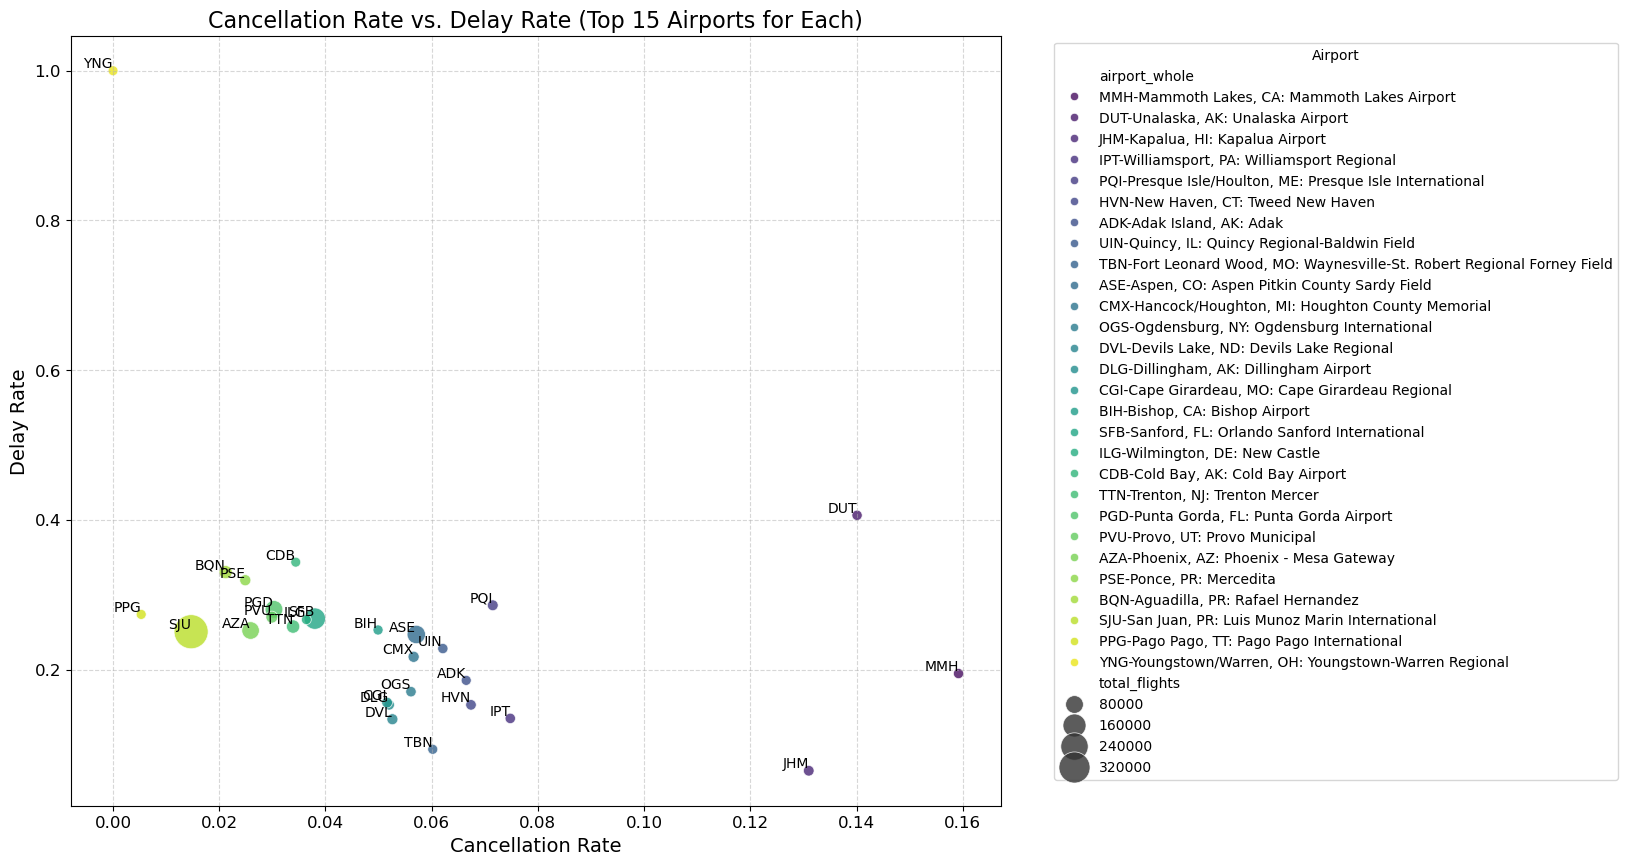

In [17]:
# Connect to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Fetch SQL query results
query = """
    SELECT 
        a.airport, 
        a.airport_name, 
        SUM(f.arr_flights) AS total_flights, 
        SUM(f.arr_cancelled) AS total_cancelled, 
        SUM(f.arr_del15) AS total_delays, 
        ROUND(CAST(SUM(f.arr_cancelled) * 1.0 / NULLIF(SUM(f.arr_flights), 0) AS NUMERIC), 4) AS cancellation_rate,
        ROUND(CAST(SUM(f.arr_del15) * 1.0 / NULLIF(SUM(f.arr_flights), 0) AS NUMERIC), 4) AS delay_rate
    FROM flight_delays_fact f
    JOIN airports_dimension a ON f.airport_key = a.airport_key
    WHERE a.airport IN ('YNG', 'DUT', 'CDB', 'BQN', 'PSE', 'PQI', 'PGD', 'PPG', 
                        'PVU', 'SFB', 'ILG', 'TTN', 'BIH', 'AZA', 'SJU', 'MMH',
                        'JHM', 'IPT', 'HVN', 'ADK', 'UIN', 'TBN', 'ASE', 'CMX',
                        'OGS', 'DVL', 'DLG', 'CGI')
    GROUP BY a.airport, a.airport_name
    ORDER BY cancellation_rate DESC;
"""

df_cancellation = pd.read_sql(query, conn)
conn.close()

df_cancellation["airport_whole"] = df_cancellation["airport"] + "-" + df_cancellation["airport_name"]

# Create scatter plot
plt.figure(figsize=(12, 10))
scatter = sns.scatterplot(
    data=df_cancellation, x="cancellation_rate", y="delay_rate",
    hue="airport_whole", size="total_flights",
    sizes=(50, 600), palette="viridis", alpha=0.8
)

# Add labels to each point using IATA codes
for i, row in df_cancellation.iterrows():
    plt.text(row["cancellation_rate"], row["delay_rate"], row["airport"], 
             fontsize=10, ha='right', va='bottom', color='black')

plt.xlabel("Cancellation Rate", fontsize=14)
plt.ylabel("Delay Rate", fontsize=14)
plt.title("Cancellation Rate vs. Delay Rate (Top 15 Airports for Each)", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.legend(title="Airport", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
plt.grid(True, linestyle="--", alpha=0.5)

plt.show()

- A clear inverse trend exists between high cancellations and high delays.
- **Small regional airports** may opt to **cancel rather than delay** (like JHM-Kapalua, HI), while **large airports prioritize keeping flights operational**.
- Airports with **extreme weather conditions** (e.g., MMH, DUT, JHM) tend to be **more cancellation-prone**.

## Question 4 How have flight delays changed over time?

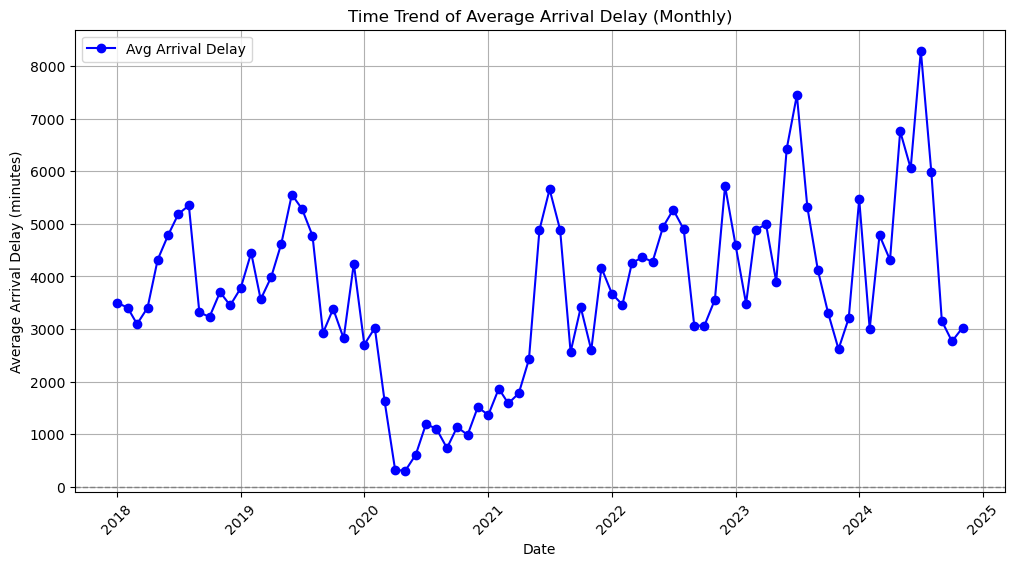

In [20]:
# Establish connection to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Create a cursor
cur = conn.cursor()

# Execute SQL query to get yearly and monthly average arrival delay
query = """
SELECT d.year, d.month, AVG(f.arr_delay) AS avg_arrival_delay
FROM flight_delays_fact f
JOIN date_dimension d ON f.date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
"""

# Fetch data into a Pandas DataFrame
df_trend = pd.read_sql(query, conn)

# Close cursor and connection
cur.close()
conn.close()

# Convert year and month into a datetime format for visualization
df_trend['date'] = pd.to_datetime(df_trend['year'].astype(str) + '-' + df_trend['month'].astype(str), format='%Y-%m')

# Plot the time trend of average arrival delays
plt.figure(figsize=(12, 6))
plt.plot(df_trend['date'], df_trend['avg_arrival_delay'], marker='o', linestyle='-', color='b', label='Avg Arrival Delay')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # Reference line at y=0

# Labels and title
plt.xlabel("Date")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Time Trend of Average Arrival Delay (Monthly)")
plt.legend()
plt.grid()

# Show the plot
plt.xticks(rotation=45)
plt.show()

Flight delays have shown a fluctuating trend over time. From 2018 to early 2020, delays exhibited a gradual increase with periodic spikes. However, around 2020, there was a sharp decline, likely due to the impact of COVID-19, which significantly reduced air traffic and airport congestion as travel restrictions were enforced worldwide.

Starting in 2021, delays began to rise again, reflecting the gradual recovery of the aviation industry. As travel demand rebounded, airlines faced challenges such as staff shortages, increased air traffic, and operational inefficiencies, contributing to greater fluctuations in delays. Over the past few years, the variability has increased, with several peaks reaching over 8,000 minutes of delay.

This trend suggests that while air travel has recovered post-pandemic, new challenges—such as airport capacity constraints, weather disruptions, and staffing issues—may be causing more unpredictable and frequent delays in recent years.

## Question 5 Do controllable delays have a seasonal pattern?

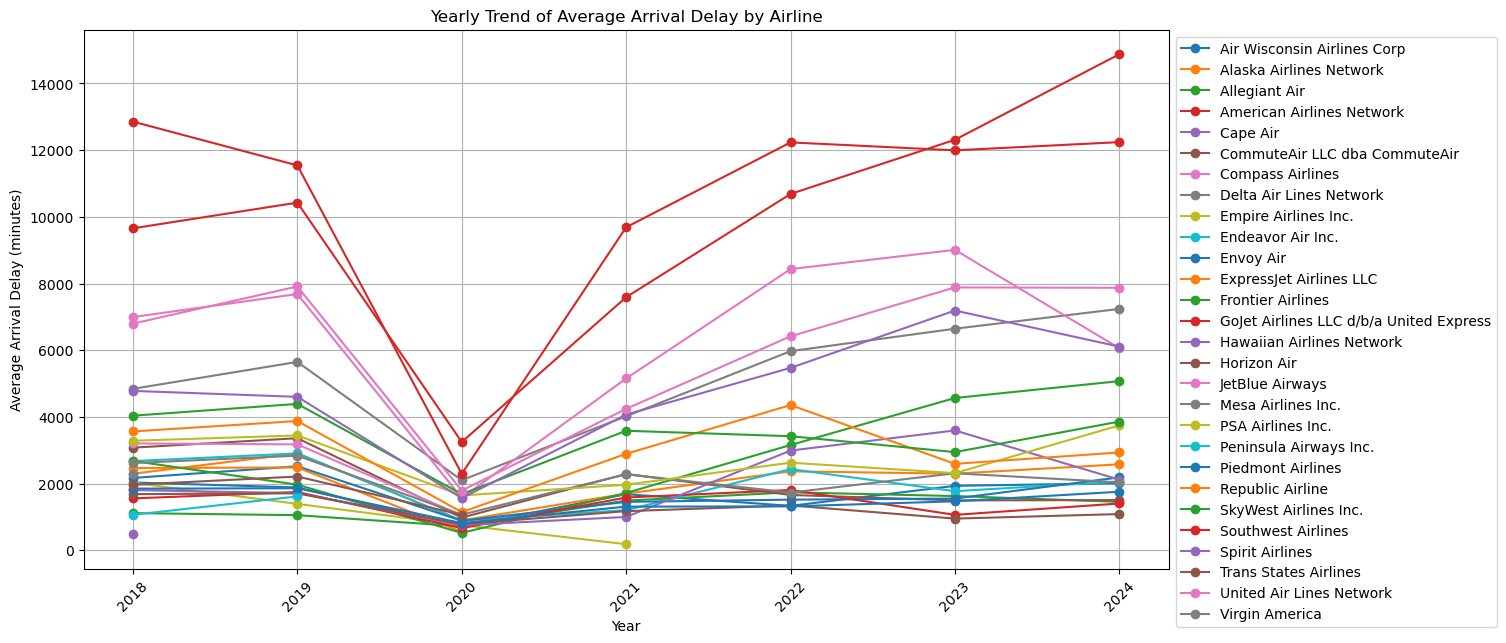

In [23]:
# Establish connection to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Create a cursor
cur = conn.cursor()

# Execute SQL query to get yearly average arrival delay for each airline
query = """
SELECT d.year, c.carrier_name, AVG(f.arr_delay) AS avg_arrival_delay
FROM flight_delays_fact f
JOIN date_dimension d ON f.date_key = d.date_key
JOIN airlines_dimension c ON f.carrier_key = c.carrier_key
GROUP BY d.year, c.carrier_name
ORDER BY d.year, avg_arrival_delay DESC;
"""

# Fetch data into a Pandas DataFrame
df_airline_trend = pd.read_sql(query, conn)

# Close cursor and connection
cur.close()
conn.close()

# Pivot data for visualization
df_pivot = df_airline_trend.pivot(index="year", columns="carrier_name", values="avg_arrival_delay")

# Plot the airline delay trends over time
plt.figure(figsize=(14, 7))

# Plot multiple airline trends
for carrier in df_pivot.columns:
    plt.plot(df_pivot.index, df_pivot[carrier], marker='o', linestyle='-', label=carrier)

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Yearly Trend of Average Arrival Delay by Airline")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid()

# Show the plot
plt.xticks(rotation=45)
plt.show()

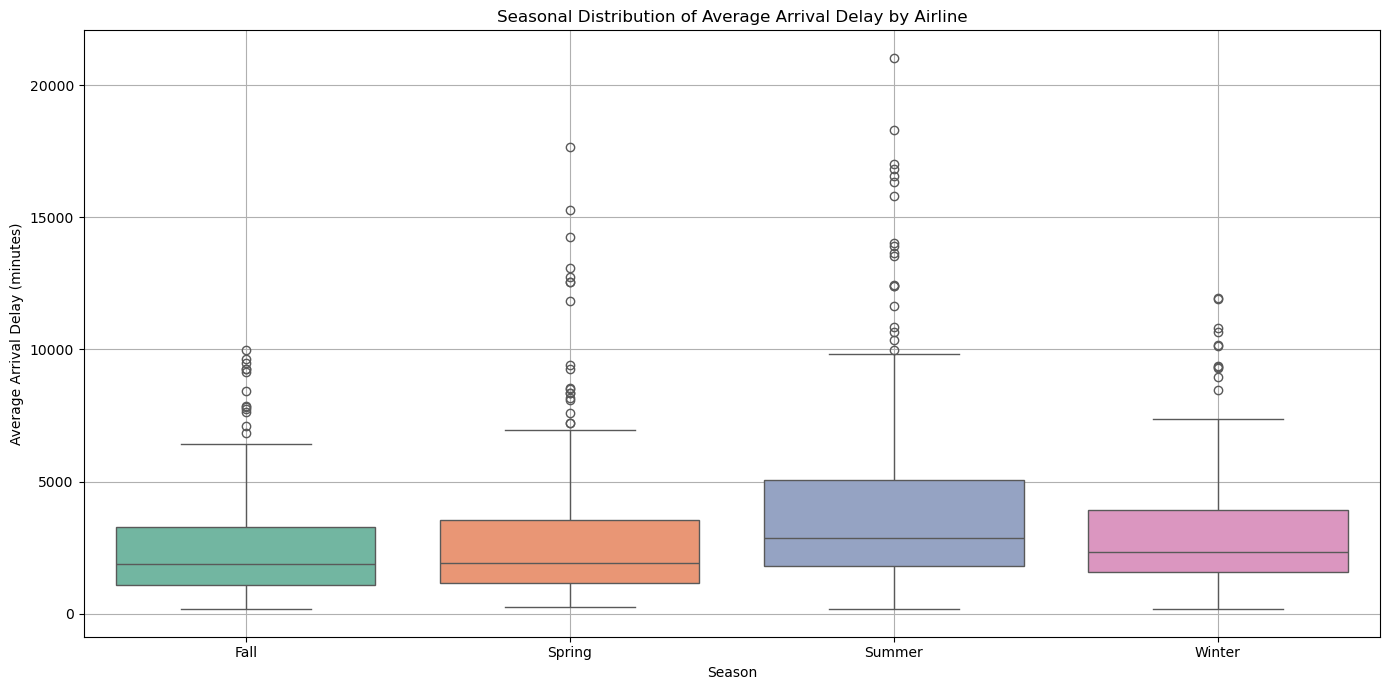

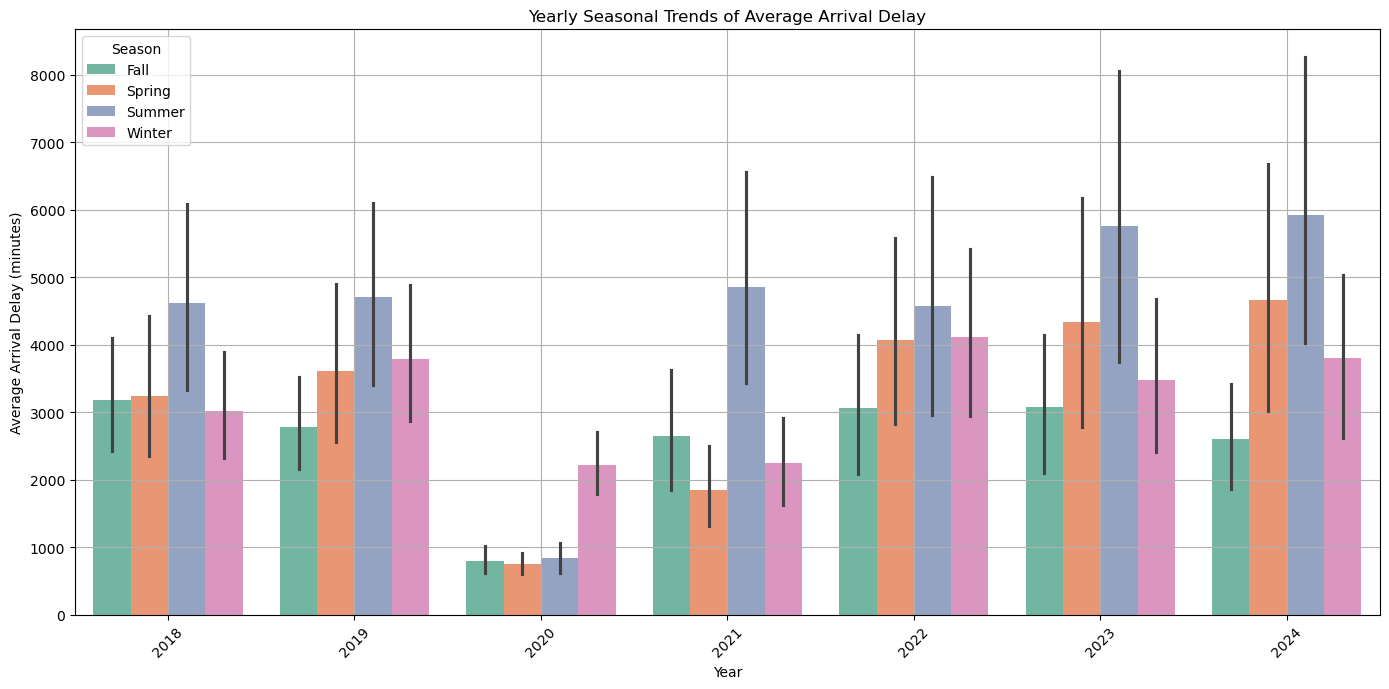

In [24]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Establish connection to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Create a cursor
cur = conn.cursor()

# SQL Query: Grouping by season and year to analyze trends
query = """
SELECT 
    d.year, 
    CASE 
        WHEN d.month IN (12, 1, 2) THEN 'Winter'
        WHEN d.month IN (3, 4, 5) THEN 'Spring'
        WHEN d.month IN (6, 7, 8) THEN 'Summer'
        WHEN d.month IN (9, 10, 11) THEN 'Fall'
    END AS season,
    c.carrier_name, 
    AVG(f.arr_delay) AS avg_arrival_delay
FROM flight_delays_fact f
JOIN date_dimension d ON f.date_key = d.date_key
JOIN airlines_dimension c ON f.carrier_key = c.carrier_key
GROUP BY d.year, season, c.carrier_name
ORDER BY d.year, season, avg_arrival_delay DESC;
"""

# Execute query and fetch data
cur.execute(query)
results = cur.fetchall()

# Create DataFrame from results
df_airline_season_trend = pd.DataFrame(results, columns=['year', 'season', 'carrier_name', 'avg_arrival_delay'])

# Boxplot: Seasonal Distribution of Average Arrival Delay
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_airline_season_trend, x="season", y="avg_arrival_delay", hue="season", palette="Set2", legend=False)

# Labels and title
plt.xlabel("Season")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Seasonal Distribution of Average Arrival Delay by Airline")
plt.grid()

# Show the plot
plt.tight_layout()
plt.show()

# Grouped Bar Chart: Yearly Seasonal Trends of Average Arrival Delay
plt.figure(figsize=(14, 7))
sns.barplot(data=df_airline_season_trend, x="year", y="avg_arrival_delay", hue="season", palette="Set2")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Average Arrival Delay (minutes)")
plt.title("Yearly Seasonal Trends of Average Arrival Delay")
plt.legend(title="Season")
plt.grid()

# Show the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Close cursor and connection
cur.close()
conn.close()

The boxplot analysis shows that summer has the highest median delays and the most extreme outliers, suggesting that increased air traffic, operational inefficiencies, and potential weather-related disruptions contribute to longer delays during this period. Winter also shows significant variability, likely due to adverse weather conditions affecting airport operations, causing delays and cancellations. In contrast, spring and fall generally have lower delays, indicating smoother airline operations during these seasons.

The grouped bar chart further confirms this pattern, showing that delays tend to peak in summer and winter, especially in recent years. The impact of COVID-19 in 2020 is evident, where delays dropped significantly due to reduced flight operations, but from 2021 onward, the seasonal variations became more pronounced again. This suggests that as air travel rebounded, challenges such as staff shortages, higher passenger volumes, and operational inefficiencies contributed to increased seasonal delays.

Overall, the data indicates that controllable delays follow a seasonal trend, with summer and winter experiencing higher delays, while spring and fall generally see fewer disruptions. This trend aligns with expectations, as peak travel seasons (summer vacations, holiday periods) and winter weather disruptions often lead to longer delays and increased operational challenges for airlines.

## Question 6 How does weather-related delay vary over the months/seasons?

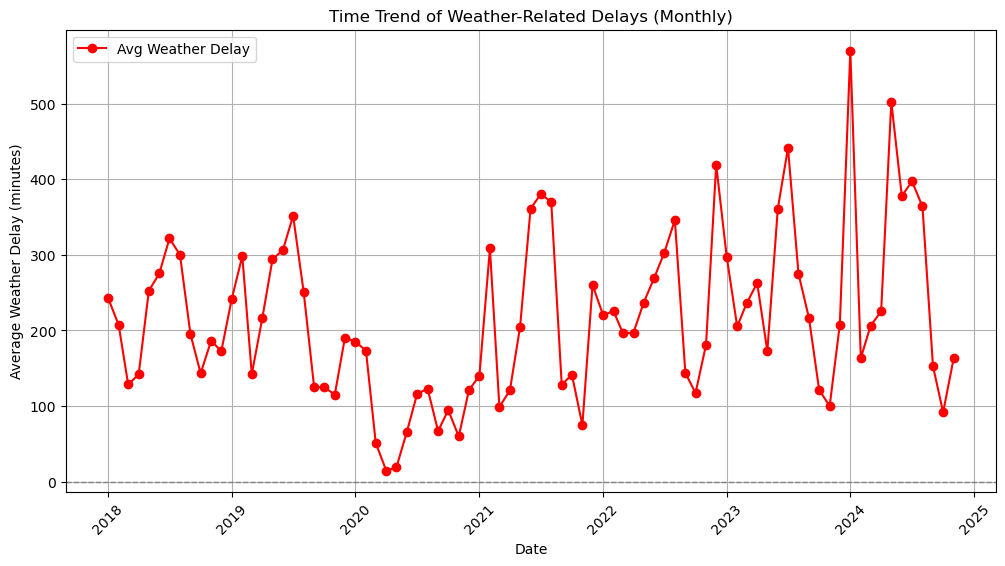

In [27]:
# Establish connection to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Create a cursor
cur = conn.cursor()

# Execute SQL query to get monthly weather-related delays
query = """
SELECT d.year, d.month, AVG(f.weather_delay) AS avg_weather_delay
FROM flight_delays_fact f
JOIN date_dimension d ON f.date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
"""

# Fetch data into a Pandas DataFrame
df_weather_trend = pd.read_sql(query, conn)

# Close cursor and connection
cur.close()
conn.close()

# Convert year and month into a datetime format for visualization
df_weather_trend['date'] = pd.to_datetime(df_weather_trend['year'].astype(str) + '-' + df_weather_trend['month'].astype(str), format='%Y-%m')

# Plot the time trend of weather-related delays
plt.figure(figsize=(12, 6))
plt.plot(df_weather_trend['date'], df_weather_trend['avg_weather_delay'], marker='o', linestyle='-', color='r', label='Avg Weather Delay')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)  # Reference line at y=0

# Labels and title
plt.xlabel("Date")
plt.ylabel("Average Weather Delay (minutes)")
plt.title("Time Trend of Weather-Related Delays (Monthly)")
plt.legend()
plt.grid()

# Show the plot
plt.xticks(rotation=45)
plt.show()

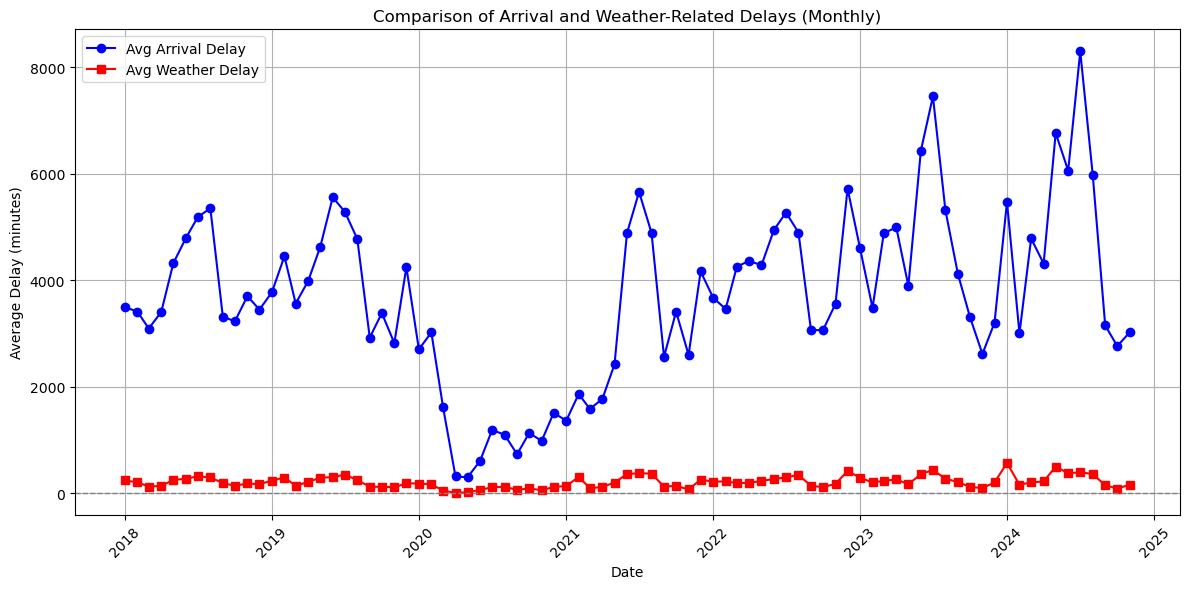

In [28]:
# Connect to PostgreSQL database using psycopg2
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Create a cursor object
cursor = conn.cursor()

# Query for average arrival delay
query_arrival_delay = """
SELECT d.year, d.month, AVG(f.arr_delay) AS avg_arrival_delay
FROM flight_delays_fact f
JOIN date_dimension d ON f.date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
"""

# Query for weather-related delay
query_weather_delay = """
SELECT d.year, d.month, AVG(f.weather_delay) AS avg_weather_delay
FROM flight_delays_fact f
JOIN date_dimension d ON f.date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
"""

# Execute queries and fetch data
cursor.execute(query_arrival_delay)
arrival_data = cursor.fetchall()

cursor.execute(query_weather_delay)
weather_data = cursor.fetchall()

# Create DataFrames from fetched data
df_arrival_trend = pd.DataFrame(arrival_data, columns=['year', 'month', 'avg_arrival_delay'])
df_weather_trend = pd.DataFrame(weather_data, columns=['year', 'month', 'avg_weather_delay'])

# Convert year and month into a datetime format for visualization
df_arrival_trend['date'] = pd.to_datetime(
    df_arrival_trend['year'].astype(str) + '-' + df_arrival_trend['month'].astype(str).str.zfill(2),
    format='%Y-%m'
)
df_weather_trend['date'] = pd.to_datetime(
    df_weather_trend['year'].astype(str) + '-' + df_weather_trend['month'].astype(str).str.zfill(2),
    format='%Y-%m'
)

# Create a plot
plt.figure(figsize=(12, 6))

# Plot average arrival delay trend
plt.plot(df_arrival_trend['date'], df_arrival_trend['avg_arrival_delay'], marker='o', linestyle='-', color='b', label='Avg Arrival Delay')

# Plot weather-related delay trend
plt.plot(df_weather_trend['date'], df_weather_trend['avg_weather_delay'], marker='s', linestyle='-', color='r', label='Avg Weather Delay')

# Add a reference line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Average Delay (minutes)")
plt.title("Comparison of Arrival and Weather-Related Delays (Monthly)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

# Close cursor and connection
cursor.close()
conn.close()

Weather-related delays exhibit fluctuating trends across months and seasons, with notable peaks and variations. The first chart shows that weather delays are not constant but vary significantly over time, with periods of increased delays followed by declines. There are noticeable spikes, particularly in recent years, suggesting seasonal or extreme weather events affecting flight operations.

The second chart, which compares arrival delays and weather-related delays, indicates that while weather delays contribute to overall delays, they are relatively small in magnitude compared to total arrival delays. This suggests that other factors, such as operational inefficiencies, airport congestion, or airline-related issues, have a greater impact on total delays.

From a seasonal perspective, weather delays tend to increase during winter and summer months, likely due to winter storms, hurricanes, and summer thunderstorms, which can severely impact flight schedules. Conversely, spring and fall generally experience fewer weather-related delays, as these seasons tend to have more stable weather conditions.

Weather-related delays follow a seasonal pattern, with higher delays observed during extreme weather periods in winter and summer and relatively lower delays in spring and fall. However, compared to total arrival delays, weather-related disruptions play a smaller role in the overall delay trends.

## Question 7 How has the flight cancellation rate changed over time?

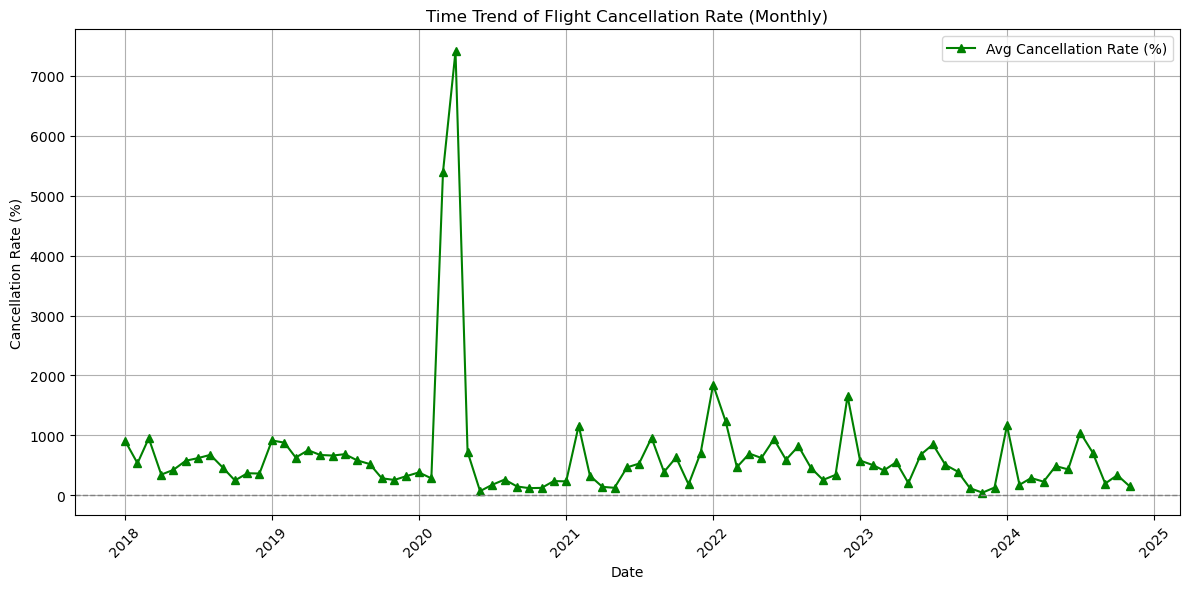

In [31]:
# Connect to PostgreSQL database using psycopg2
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Create a cursor object
cursor = conn.cursor()

# Query for cancellation rate
query_cancellation_rate = """
SELECT d.year, d.month, AVG(f.arr_cancelled) AS avg_cancellation_rate
FROM flight_delays_fact f
JOIN date_dimension d ON f.date_key = d.date_key
GROUP BY d.year, d.month
ORDER BY d.year, d.month;
"""

# Execute query and fetch data
cursor.execute(query_cancellation_rate)
cancellation_data = cursor.fetchall()

# Create DataFrame from fetched data
df_cancellation_trend = pd.DataFrame(cancellation_data, columns=['year', 'month', 'avg_cancellation_rate'])

# Convert year and month into a datetime format for visualization
df_cancellation_trend['date'] = pd.to_datetime(
    df_cancellation_trend['year'].astype(str) + '-' + df_cancellation_trend['month'].astype(str).str.zfill(2),
    format='%Y-%m'
)

# Create a plot for cancellation rate trend
plt.figure(figsize=(12, 6))

# Plot cancellation rate (converted to percentage)
plt.plot(df_cancellation_trend['date'], df_cancellation_trend['avg_cancellation_rate'] * 100, 
         marker='^', linestyle='-', color='g', label='Avg Cancellation Rate (%)')

# Add a reference line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)

# Labels, title, and legend
plt.xlabel("Date")
plt.ylabel("Cancellation Rate (%)")
plt.title("Time Trend of Flight Cancellation Rate (Monthly)")
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot
plt.show()

# Close cursor and connection
cursor.close()
conn.close()

The flight cancellation rate has experienced significant fluctuations over time, with a major spike in early 2020, likely due to the impact of COVID-19 and global travel restrictions. This unprecedented increase aligns with the period when airlines drastically reduced operations, leading to widespread cancellations. After this peak, the cancellation rate dropped sharply and remained relatively low throughout late 2020 and early 2021 as travel demand was still recovering.

From 2021 onward, cancellation rates began to show periodic fluctuations, with noticeable spikes occurring at certain points. These increases could be attributed to operational disruptions, seasonal weather events, or airline staffing shortages, which have become more prevalent in the post-pandemic period. While the overall cancellation rate has stabilized compared to 2020, it has not returned to pre-pandemic levels and still exhibits occasional surges, indicating that the airline industry continues to face logistical and operational challenges.

The trend suggests that while the aviation industry has largely recovered from the pandemic, flight cancellations remain a recurring issue, influenced by factors such as weather, operational inefficiencies, and travel demand fluctuations.

## Question 8 Find out which airlines are most likely to have delays and provide a longer time-estimation for specific airlines.¶

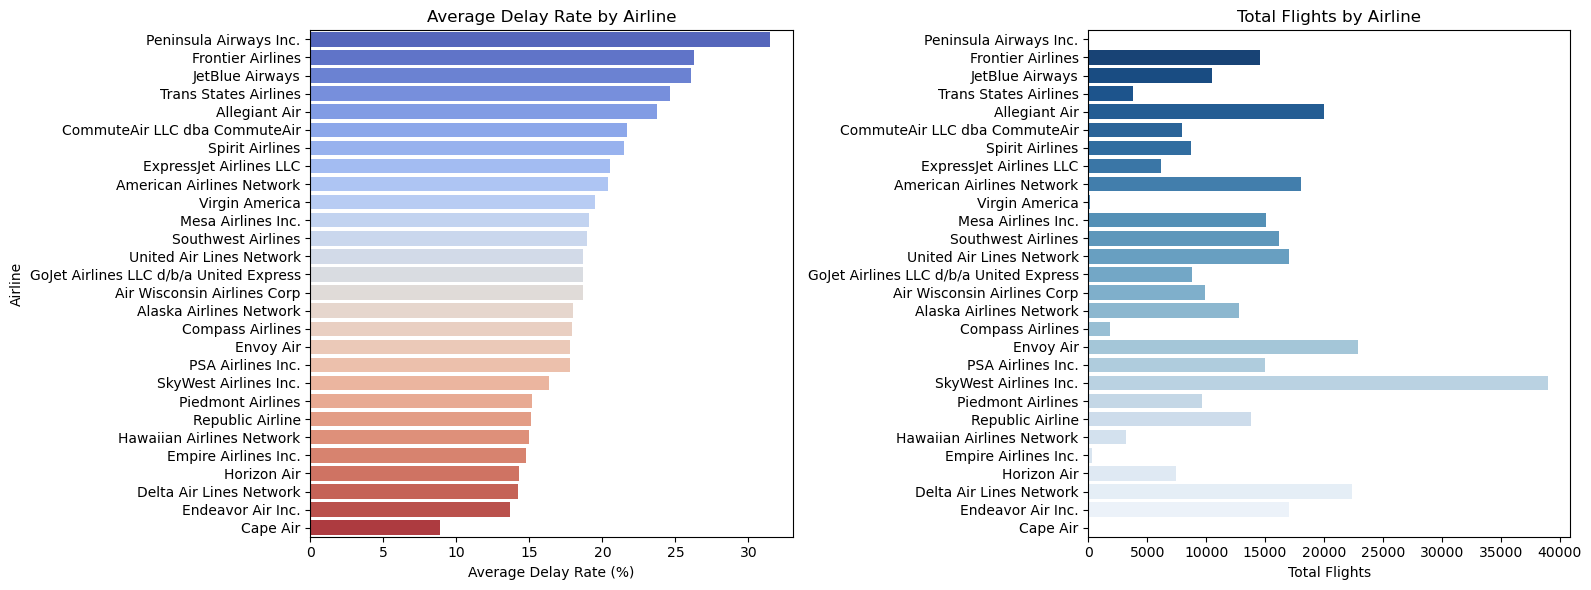

In [34]:
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Ignore warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# Establish connection to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Create a cursor
cur = conn.cursor()

# SQL query
query = """
SELECT 
    c.carrier_name,
    COUNT(f.arr_flights) AS total_flights,
    ROUND(SUM(f.arr_del15)::NUMERIC * 100.0 / NULLIF(SUM(f.arr_flights)::NUMERIC, 0), 2) AS avg_delay_rate,
    ROUND(AVG(f.arr_delay)::NUMERIC, 2) AS avg_arrival_delay
FROM flight_delays_fact f
JOIN airlines_dimension c ON f.carrier_key = c.carrier_key
WHERE f.arr_flights IS NOT NULL AND f.arr_del15 IS NOT NULL  
GROUP BY c.carrier_name
ORDER BY avg_delay_rate DESC, avg_arrival_delay DESC;
"""

# Fetch data into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Close cursor and connection
cur.close()
conn.close()


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.barplot(data=df, x="avg_delay_rate", y="carrier_name", palette="coolwarm", ax=axes[0])
axes[0].set_xlabel("Average Delay Rate (%)")
axes[0].set_ylabel("Airline")
axes[0].set_title("Average Delay Rate by Airline")

sns.barplot(data=df, x="total_flights", y="carrier_name", palette="Blues_r", ax=axes[1])
axes[1].set_xlabel("Total Flights")
axes[1].set_ylabel("")
axes[1].set_title("Total Flights by Airline")

plt.tight_layout()
plt.show()


eninsula Airways Inc., Frontier Airlines, and JetBlue Airways have the highest average delay rates.Airlines such as Southwest Airlines, American Airlines Network, and United Airlines Network also experience notable delays but have a high volume of flights.The data shows variation in delay rates among different airlines, with some having consistently higher delays than others

## Question 9 Find out whether weather is a key factor in causing delays and adjust its estimation time according to the likelihood of severe weather conditions.

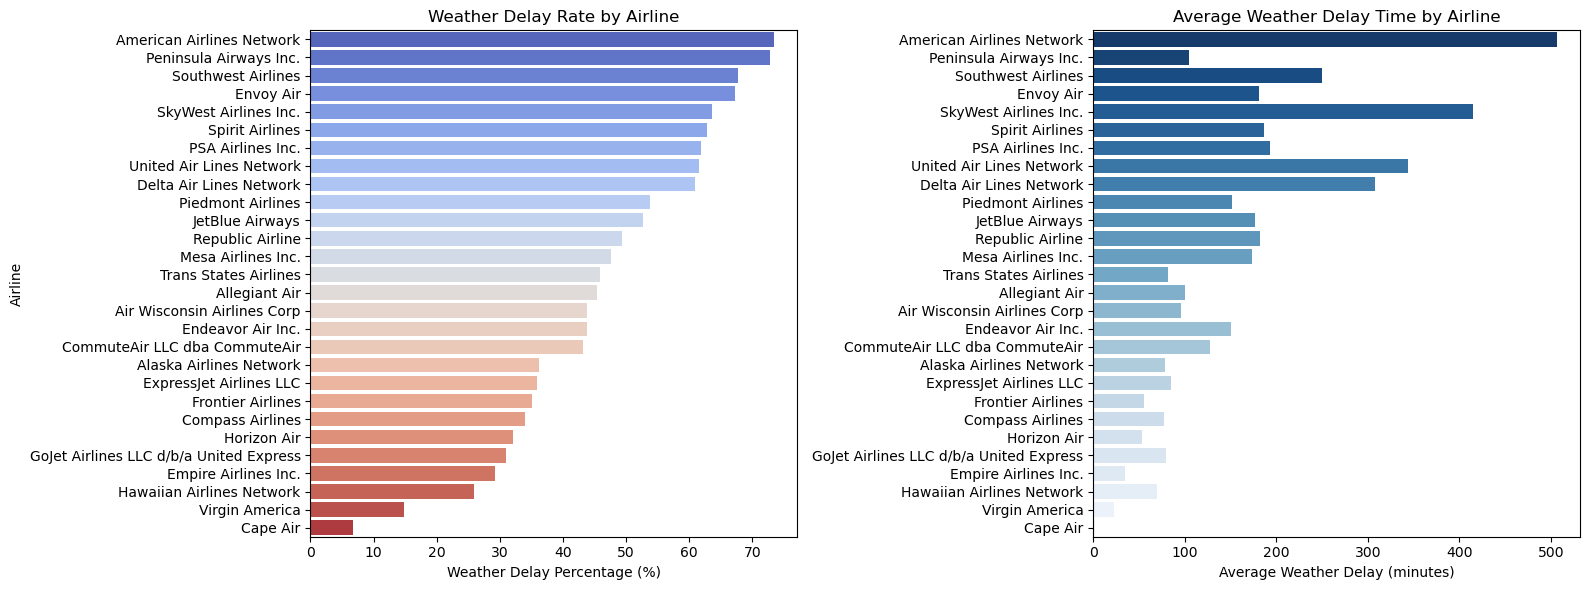

In [37]:
# Establish a connection to the PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# SQL query to retrieve weather delay data
query = """
SELECT 
    c.carrier_name,
    COUNT(*) AS total_flights,
    SUM(CASE WHEN f.weather_delay > 0 THEN 1 ELSE 0 END) AS weather_delayed_flights,
    ROUND(SUM(CASE WHEN f.weather_delay > 0 THEN 1 ELSE 0 END) * 100.0 / COUNT(*)::NUMERIC, 2) AS weather_delay_percentage,
    ROUND(AVG(f.weather_delay)::NUMERIC, 2) AS avg_weather_delay
FROM flight_delays_fact f
JOIN airlines_dimension c ON f.carrier_key = c.carrier_key
WHERE f.weather_delay IS NOT NULL
GROUP BY c.carrier_name
ORDER BY weather_delay_percentage DESC, avg_weather_delay DESC;
"""

# Read data into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Close database connection
conn.close()

# **Create subplots**
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# **Plot 1: Weather Delay Rate by Airline**
sns.barplot(data=df, x="weather_delay_percentage", y="carrier_name", palette="coolwarm", ax=axes[0])
axes[0].set_xlabel("Weather Delay Percentage (%)")
axes[0].set_ylabel("Airline")
axes[0].set_title("Weather Delay Rate by Airline")

# **Plot 2: Average Weather Delay Time by Airline**
sns.barplot(data=df, x="avg_weather_delay", y="carrier_name", palette="Blues_r", ax=axes[1])
axes[1].set_xlabel("Average Weather Delay (minutes)")
axes[1].set_ylabel("")
axes[1].set_title("Average Weather Delay Time by Airline")

# **Adjust layout**
plt.tight_layout()
plt.show()


### **Is Weather a Key Factor in Causing Delays?**
Based on the visualization, weather is a significant factor in airline delays. The **Weather Delay Rate by Airline** graph (left) shows that some airlines experience a **high percentage of weather-related delays**, with **American Airlines Network, Peninsula Airways Inc., and Southwest Airlines** having the highest weather delay percentages. 

The **Average Weather Delay Time by Airline** graph (right) highlights that while some airlines have a **high percentage of weather delays**, their **average delay times vary significantly**. For example:
**American Airlines Network** not only has the highest weather delay percentage but also has the longest average weather delay time.
**Peninsula Airways Inc. and Southwest Airlines** also face frequent weather delays but with comparatively lower delay times.
**Other airlines like ExpressJet Airlines LLC and Frontier Airlines** have **lower weather delay percentages** but may still experience **significant delay durations** when affected.

### **Adjusting Estimation Time for Severe Weather Conditions**
1. **Airlines with high weather delay percentages** should prepare for frequent disruptions by adjusting their flight schedules proactively.
2. **Airlines with long average weather delays** should extend their estimated arrival times and improve contingency planning.

## Question 10 How to optimize air traffic control & take off time schedule after understanding the delay reasons for airlines?

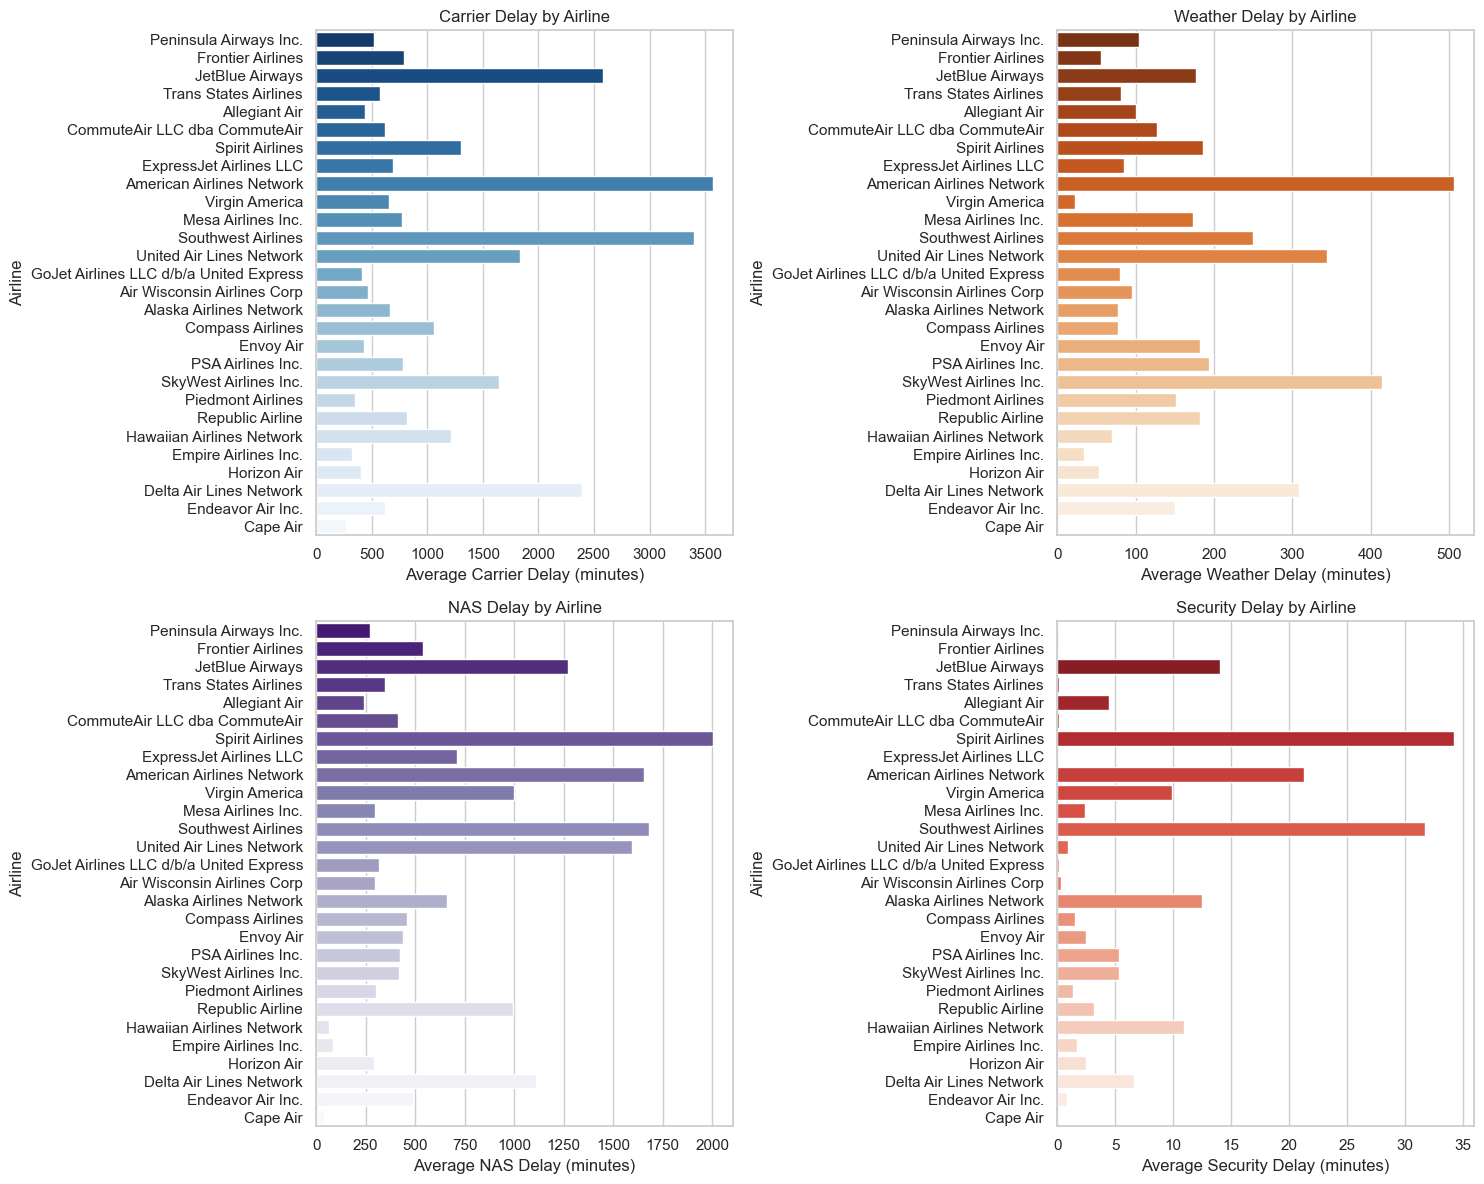

In [40]:
# Establish connection to PostgreSQL database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)

# Define SQL query
query = """
SELECT 
    c.carrier_name,
    COUNT(*) AS total_flights,
    ROUND(SUM(f.arr_del15)::NUMERIC * 100.0 / NULLIF(SUM(f.arr_flights)::NUMERIC, 0), 2) AS avg_delay_rate,
    ROUND(AVG(f.arr_delay)::NUMERIC, 2) AS avg_arrival_delay,
    ROUND(AVG(f.carrier_delay)::NUMERIC, 2) AS avg_carrier_delay,
    ROUND(AVG(f.weather_delay)::NUMERIC, 2) AS avg_weather_delay,
    ROUND(AVG(f.nas_delay)::NUMERIC, 2) AS avg_nas_delay,
    ROUND(AVG(f.security_delay)::NUMERIC, 2) AS avg_security_delay,
    ROUND(AVG(f.late_aircraft_delay)::NUMERIC, 2) AS avg_late_aircraft_delay
FROM flight_delays_fact f
JOIN airlines_dimension c ON f.carrier_key = c.carrier_key
WHERE f.arr_delay IS NOT NULL
GROUP BY c.carrier_name
ORDER BY avg_delay_rate DESC, avg_arrival_delay DESC;
"""

# Fetch data into a Pandas DataFrame
df = pd.read_sql(query, conn)

# Close connection
conn.close()

# Set plot style
sns.set(style="whitegrid")

# Create subplots to visualize different delay reasons
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Carrier delay
sns.barplot(data=df, x="avg_carrier_delay", y="carrier_name", palette="Blues_r", ax=axes[0, 0])
axes[0, 0].set_xlabel("Average Carrier Delay (minutes)")
axes[0, 0].set_ylabel("Airline")
axes[0, 0].set_title("Carrier Delay by Airline")

# Weather delay
sns.barplot(data=df, x="avg_weather_delay", y="carrier_name", palette="Oranges_r", ax=axes[0, 1])
axes[0, 1].set_xlabel("Average Weather Delay (minutes)")
axes[0, 1].set_ylabel("Airline")
axes[0, 1].set_title("Weather Delay by Airline")

# NAS delay
sns.barplot(data=df, x="avg_nas_delay", y="carrier_name", palette="Purples_r", ax=axes[1, 0])
axes[1, 0].set_xlabel("Average NAS Delay (minutes)")
axes[1, 0].set_ylabel("Airline")
axes[1, 0].set_title("NAS Delay by Airline")

# Security delay
sns.barplot(data=df, x="avg_security_delay", y="carrier_name", palette="Reds_r", ax=axes[1, 1])
axes[1, 1].set_xlabel("Average Security Delay (minutes)")
axes[1, 1].set_ylabel("Airline")
axes[1, 1].set_title("Security Delay by Airline")

# Adjust layout
plt.tight_layout()
plt.show()


### **1 American Airlines Network**  
- **Delays from:** Carrier, NAS, Security, Weather  
- **Actions:**  
  - **Carrier Delay (Controllable):** Improve turnaround operations, optimize crew shifts.  
  - **Weather Delay (Uncontrollable but Mitigatable):** Invest in weather-tracking and alternative route planning.  
  - **NAS Delay (Partially Controllable):** Work with ATC to optimize flight routing.  
  - **Security Delay (Controllable):** Implement faster security screening at major hubs.  

---

### **2 ExpressJet Airlines LLC**  
- **Delays from:** Carrier, Security, NAS  
- **Actions:**  
  - **Carrier Delay (Controllable):** AI-driven aircraft maintenance scheduling.  
  - **Security Delay (Controllable):** Implement automated check-in & biometric screening.  
  - **NAS Delay (Partially Controllable):** Optimize flight plans with real-time ATC coordination.  

---

### **3 Southwest Airlines**  
- **Delays from:** NAS, Weather  
- **Actions:**  
  - **NAS Delay (Partially Controllable):** Work with FAA to prioritize takeoff slots.  
  - **Weather Delay (Uncontrollable but Mitigatable):** Expand use of flexible rerouting for severe weather.  

---

### **4 SkyWest Airlines**  
- **Delays from:** NAS, Weather  
- **Actions:**  
  - **NAS Delay (Partially Controllable):** AI-based flight re-routing & slot optimization.  
  - **Weather Delay (Uncontrollable but Mitigatable):** Use advanced weather prediction models.  

---

### **5 Spirit Airlines**  
- **Delays from:** Carrier, Security, NAS  
- **Actions:**  
  - **Carrier Delay (Controllable):** Reduce crew turnover, streamline baggage handling.  
  - **Security Delay (Controllable):** TSA PreCheck incentives for passengers.  
  - **NAS Delay (Partially Controllable):** Adjust flight schedules to off-peak hours.  

---

### **6 Alaska Airlines Network**  
- **Delays from:** NAS, Weather  
- **Actions:**  
  - **NAS Delay (Partially Controllable):** Expand partnership with ATC to prioritize flights.  
  - **Weather Delay (Uncontrollable but Mitigatable):** Improve aircraft de-icing efficiency.  


## Question 11  Analysis of Relationship Between NAS Delays and Weather Delays

## Executive Summary

This analysis explores the correlation between National Airspace System (NAS) delays and weather delays, and examines whether severe weather conditions lead to increased NAS delays. Through correlation analysis, severity-based analysis, and seasonal pattern analysis, we found a significant moderate positive correlation between weather delays and NAS delays, with the severity of weather delays directly impacting the length of NAS delays.

## Key Findings

### 1. Correlation Analysis

The data shows a moderate positive correlation between weather delays and NAS delays with a correlation coefficient of 0.6236. This indicates that as weather delays increase, NAS delays tend to increase as well, and vice versa. The scatter plot clearly demonstrates this positive correlation.

### 2. Impact of Weather Delay Severity on NAS Delays

The analysis reveals a clear incremental relationship between weather delay severity and NAS delays:

| Weather Delay Severity | Average NAS Delay (min) | Median NAS Delay (min) | Flight Count |
|------------------------|-------------------------|------------------------|--------------|
| Minimal (0-30min)      | 282.313                 | 139                    | 17612        |
| Moderate (31-60min)    | 328.571                 | 154                    | 12140        |
| Severe (61-120min)     | 447.091                 | 197                    | 14504        |
| Extreme (>120min)      | 2288.57                 | 519                    | 42236        |

Percentage increase in NAS delays from minimal level to each level:
- Minimal to Moderate: 16.39% increase
- Minimal to Severe: 58.37% increase
- Minimal to Extreme: 710.65% increase

These data clearly demonstrate that as weather delay severity increases, NAS delays increase significantly, with a dramatic spike when weather delays exceed 120 minutes.

### 3. Seasonal Pattern Analysis

Monthly analysis shows distinct seasonal patterns in the correlation between weather and NAS delays:

| Month | Avg Weather Delay | Avg NAS Delay | Correlation |
|-------|-------------------|---------------|-------------|
| Jan   | 301.734           | 827.377       | 0.582143    |
| Feb   | 249.135           | 776.385       | 0.540388    |
| Mar   | 169.371           | 790.76        | 0.52457     |
| Apr   | 205.042           | 834.676       | 0.592098    |
| May   | 292.192           | 949.811       | 0.732741    |
| Jun   | 331.415           | 1067.06       | 0.732176    |
| Jul   | 365.1             | 1129.56       | 0.759468    |
| Aug   | 323.238           | 1066.76       | 0.699226    |
| Sep   | 174.393           | 713.273       | 0.621521    |
| Oct   | 139.241           | 649.092       | 0.497965    |
| Nov   | 146.383           | 632.347       | 0.474477    |
| Dec   | 252.921           | 762.772       | 0.392272    |

The correlation is strongest during summer months (May-August) with coefficients around 0.7, and weakest during winter months (November-February), particularly December with a correlation coefficient of only 0.39. This may indicate that summer weather phenomena such as thunderstorms affect the aviation system differently than winter phenomena like snowstorms.

## Conclusions

1. **Significant Correlation Exists**: A moderate positive correlation of 0.6236 exists between weather delays and NAS delays, indicating a strong connection between the two.

2. **Weather Severity Impact**: As weather delay severity increases, NAS delays increase significantly. When weather delays exceed 120 minutes (extreme level), NAS delays increase by 710.65%, indicating that severe weather delays create a cascade effect throughout the air traffic control system.

3. **Seasonal Influence**: The correlation between weather and NAS delays is strongest during summer months (May-August) and relatively weaker during winter months, suggesting different mechanisms of impact from different seasonal weather patterns on the air traffic system.

## Recommendations

Based on the analysis results, we recommend the following:

1. **Improve Contingency Plans for Extreme Weather**: Given the massive impact of extreme weather delays (>120 minutes) on NAS delays (710.65% increase), aviation management should particularly focus on and enhance emergency response mechanisms for these situations.

2. **Seasonal Adjustments**: Considering the high correlation in summer months (May-August), airlines and air traffic management may need to add extra buffer time and resources during these months.

3. **Early Warning Systems**: Develop more precise weather impact prediction models, with special attention to situations where weather delays might exceed 60 minutes, as this is the threshold where NAS delays begin to increase significantly.

4. **Resource Optimization**: Based on monthly patterns, adjust human and equipment resources appropriately across different months to address the varying impacts of weather delays on the NAS system throughout the year.

Total records analyzed: 283376

Question: Is there a correlation between NAS delays and weather delays?
Pearson correlation coefficient: 0.6236 (p-value: 0.000000)
Spearman correlation coefficient: 0.4827 (p-value: 0.000000)

Interpretation: There is a moderate 0.6236 correlation between weather delays and NAS delays.
This correlation is statistically significant (p < 0.05).

Question: Does severe weather often lead to increased NAS delays?

Average NAS delay by weather delay severity:
+---------------------+-----------------+--------------------+----------------+
| weather_severity    |   avg_nas_delay |   median_nas_delay |   flight_count |
|---------------------+-----------------+--------------------+----------------|
| Minimal (0-30min)   |         282.313 |                139 |          35224 |
| Moderate (31-60min) |         328.571 |                154 |          24280 |
| Severe (61-120min)  |         447.091 |                197 |          29008 |
| Extreme (>120min)   |      

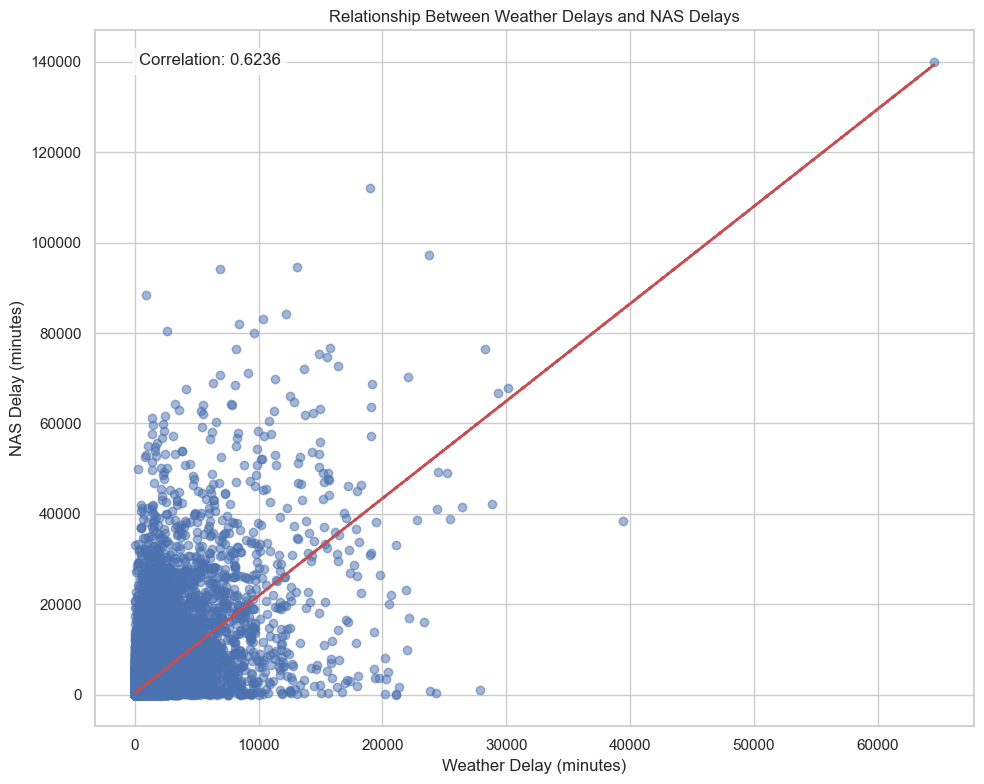

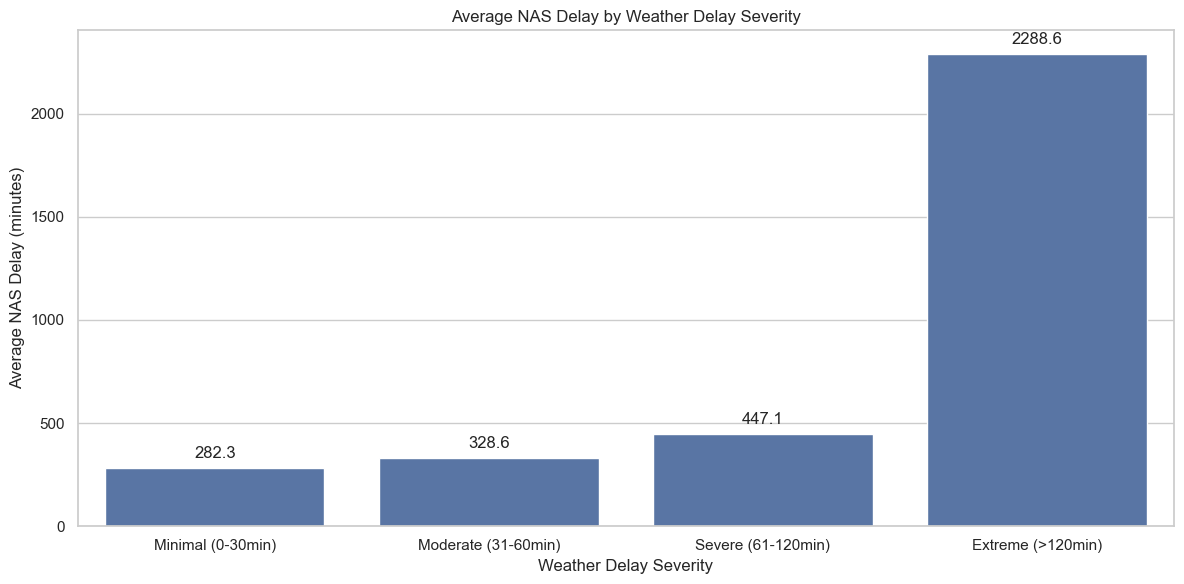

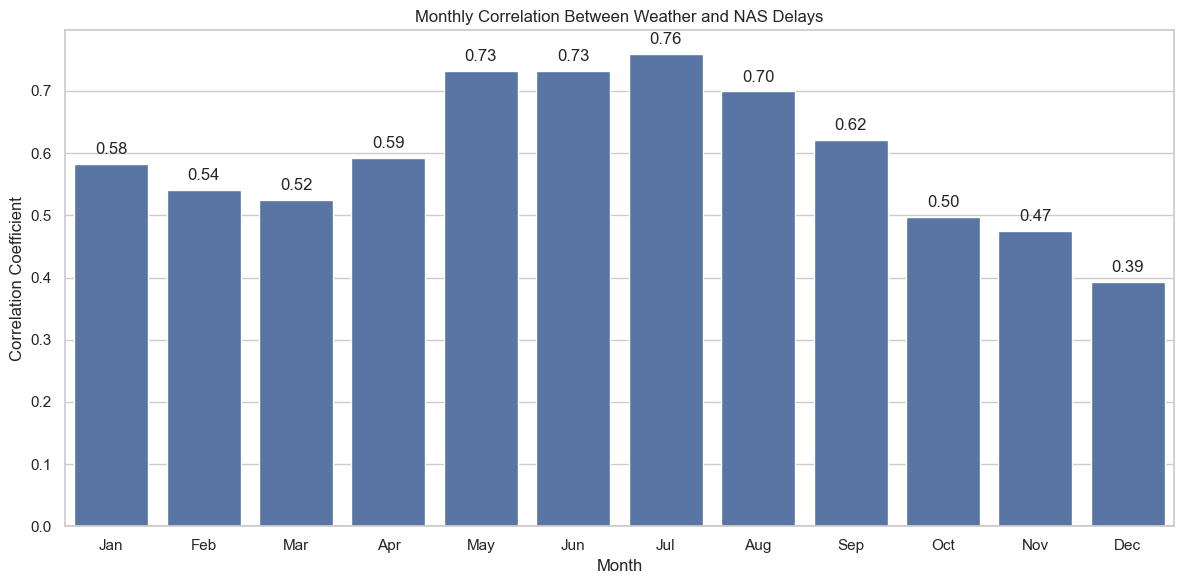

In [43]:
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)
cur = conn.cursor()
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from tabulate import tabulate


# Query to fetch weather and NAS delay data
query = """
SELECT 
    date_key, 
    airport_key, 
    carrier_key,
    weather_delay,
    nas_delay
FROM 
    flight_delays_fact
WHERE 
    weather_delay > 0 OR nas_delay > 0
"""

try:
    # Execute query
    cur.execute(query)
    results = cur.fetchall()
    
    # Create DataFrame
    df = pd.DataFrame(results, columns=['date_key', 'airport_key', 'carrier_key', 'weather_delay', 'nas_delay'])
    
    print(f"Total records analyzed: {len(df)}")
    
    # 1. Calculate Pearson correlation between weather delay and NAS delay
    corr_pearson, p_value_pearson = pearsonr(df['weather_delay'], df['nas_delay'])
    
    # 2. Calculate Spearman rank correlation (less sensitive to outliers)
    corr_spearman, p_value_spearman = spearmanr(df['weather_delay'], df['nas_delay'])
    
    print("\nQuestion: Is there a correlation between NAS delays and weather delays?")
    print("="*80)
    
    print(f"Pearson correlation coefficient: {corr_pearson:.4f} (p-value: {p_value_pearson:.6f})")
    print(f"Spearman correlation coefficient: {corr_spearman:.4f} (p-value: {p_value_spearman:.6f})")
    
    # Interpret correlation strength
    if abs(corr_pearson) < 0.3:
        strength = "weak"
    elif abs(corr_pearson) < 0.7:
        strength = "moderate"
    else:
        strength = "strong"
        
    print(f"\nInterpretation: There is a {strength} {corr_pearson:.4f} correlation between weather delays and NAS delays.")
    if p_value_pearson < 0.05:
        print("This correlation is statistically significant (p < 0.05).")
    else:
        print("This correlation is not statistically significant (p >= 0.05).")
    
    # 3. Create scatter plot to visualize relationship
    plt.figure(figsize=(10, 8))
    plt.scatter(df['weather_delay'], df['nas_delay'], alpha=0.3)
    plt.title('Relationship Between Weather Delays and NAS Delays')
    plt.xlabel('Weather Delay (minutes)')
    plt.ylabel('NAS Delay (minutes)')
    
    # Add best fit line
    z = np.polyfit(df['weather_delay'], df['nas_delay'], 1)
    p = np.poly1d(z)
    plt.plot(df['weather_delay'], p(df['weather_delay']), "r--", linewidth=2)
    
    plt.text(0.05, 0.95, f"Correlation: {corr_pearson:.4f}", transform=plt.gca().transAxes, 
             bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('weather_nas_correlation.png')
    
    # 4. Analyze if severe weather leads to increased NAS delays
    # Categorize weather delays into severity levels
    df['weather_severity'] = pd.cut(
        df['weather_delay'], 
        bins=[0, 30, 60, 120, np.inf], 
        labels=['Minimal (0-30min)', 'Moderate (31-60min)', 'Severe (61-120min)', 'Extreme (>120min)']
    )
    
    # Calculate average NAS delay for each weather severity level
    nas_by_weather = df.groupby('weather_severity')['nas_delay'].agg(['mean', 'median', 'count']).reset_index()
    nas_by_weather = nas_by_weather.rename(columns={'mean': 'avg_nas_delay', 'median': 'median_nas_delay', 'count': 'flight_count'})
    
    print("\nQuestion: Does severe weather often lead to increased NAS delays?")
    print("="*80)
    print("\nAverage NAS delay by weather delay severity:")
    print(tabulate(nas_by_weather, headers='keys', tablefmt='psql', showindex=False))
    
    # Calculate the percentage increase in NAS delays as weather severity increases
    baseline = nas_by_weather.loc[0, 'avg_nas_delay']
    for i in range(1, len(nas_by_weather)):
        current = nas_by_weather.loc[i, 'avg_nas_delay']
        increase = ((current - baseline) / baseline) * 100
        print(f"NAS delay increase from {nas_by_weather.loc[0, 'weather_severity']} to {nas_by_weather.loc[i, 'weather_severity']}: {increase:.2f}%")
    
    # 5. Create bar chart showing average NAS delay by weather severity
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='weather_severity', y='avg_nas_delay', data=nas_by_weather)
    plt.title('Average NAS Delay by Weather Delay Severity')
    plt.xlabel('Weather Delay Severity')
    plt.ylabel('Average NAS Delay (minutes)')
    
    # Add data labels on bars
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.1f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom',
                   xytext = (0, 5), textcoords = 'offset points')
    
    plt.tight_layout()
    plt.savefig('nas_delay_by_weather_severity.png')
    
    # 6. Additional analysis: Look at month-by-month patterns (seasonal effects)
    query_monthly = """
    SELECT 
        d.month,
        AVG(f.weather_delay) AS avg_weather_delay,
        AVG(f.nas_delay) AS avg_nas_delay,
        CORR(f.weather_delay, f.nas_delay) AS correlation
    FROM 
        flight_delays_fact f
    JOIN
        date_dimension d ON f.date_key = d.date_key
    WHERE 
        f.weather_delay > 0 OR f.nas_delay > 0
    GROUP BY 
        d.month
    ORDER BY 
        d.month
    """
    
    cur.execute(query_monthly)
    results_monthly = cur.fetchall()
    
    df_monthly = pd.DataFrame(results_monthly, 
                             columns=['month', 'avg_weather_delay', 'avg_nas_delay', 'correlation'])
    
    # Add month names
    month_names = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
                  7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
    df_monthly['month_name'] = df_monthly['month'].map(month_names)
    
    print("\nMonthly Analysis of Weather and NAS Delays:")
    print("="*80)
    print(tabulate(df_monthly[['month_name', 'avg_weather_delay', 'avg_nas_delay', 'correlation']], 
                  headers=['Month', 'Avg Weather Delay', 'Avg NAS Delay', 'Correlation'], 
                  tablefmt='psql', showindex=False))
    
    # Plot monthly correlations
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(x='month_name', y='correlation', data=df_monthly)
    plt.title('Monthly Correlation Between Weather and NAS Delays')
    plt.xlabel('Month')
    plt.ylabel('Correlation Coefficient')
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)  # Add reference line at 0
    
    # Add data labels
    for i, p in enumerate(ax.patches):
        ax.annotate(f"{p.get_height():.2f}", 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'bottom' if p.get_height() > 0 else 'top',
                   xytext = (0, 5 if p.get_height() > 0 else -5), 
                   textcoords = 'offset points')
    
    plt.tight_layout()
    plt.savefig('monthly_weather_nas_correlation.png')
    
    # 7. Summary of findings
    print("\nSummary of Findings:")
    print("="*80)
    print(f"1. There is a {strength} correlation ({corr_pearson:.4f}) between weather delays and NAS delays.")
    
    # Check if NAS delays increase with weather severity
    if nas_by_weather['avg_nas_delay'].is_monotonic_increasing:
        print("2. NAS delays consistently increase as weather delays become more severe.")
    else:
        print("2. The relationship between weather severity and NAS delays is not consistently increasing.")
    
    # Find months with highest correlation
    top_corr_months = df_monthly.nlargest(3, 'correlation')
    print(f"3. The strongest weather-NAS delay correlations occur in: " + 
          ", ".join([f"{row['month_name']} ({row['correlation']:.2f})" for _, row in top_corr_months.iterrows()]))
    
    # Check if correlation is seasonal
    winter_corr = df_monthly[df_monthly['month'].isin([12, 1, 2])]['correlation'].mean()
    summer_corr = df_monthly[df_monthly['month'].isin([6, 7, 8])]['correlation'].mean()
    
    if winter_corr > summer_corr:
        print(f"4. The correlation is stronger in winter months ({winter_corr:.2f}) than summer months ({summer_corr:.2f}).")
    else:
        print(f"4. The correlation is stronger in summer months ({summer_corr:.2f}) than winter months ({winter_corr:.2f}).")
    
except Exception as e:
    print(f"Error analyzing NAS and weather delay correlation: {e}")
finally:
    # Close cursor and connection
    cur.close()
    conn.close()
    
print("\nAnalysis complete. Charts saved as 'weather_nas_correlation.png', 'nas_delay_by_weather_severity.png', " +
      "and 'monthly_weather_nas_correlation.png'")

## Question 12 Is there a correlation between different types of flight delays and cancellation rates


1. **Positive correlation between carrier delays and cancellation rates**: The data shows the strongest positive correlation (correlation coefficient around 0.3) between carrier delay percentage and cancellation rate, indicating that airline operational issues are an important predictor of flight cancellations.

2. **Negative correlation between late aircraft delays and cancellation rates**: There is a notable negative correlation between late aircraft delay percentage and cancellation rate, suggesting that when airlines choose to wait for delayed aircraft rather than cancel flights, this type of delay percentage increases.

3. **Anomalous patterns during the 2020 pandemic**: During the early COVID-19 pandemic in 2020, flight cancellation rates peaked at approximately 40%, while carrier delay percentages surged to over 60%, and late aircraft delay percentages significantly decreased.

4. **Stability in delay type distribution**: Under normal conditions, late aircraft delays and carrier delays are the two primary delay types, each accounting for 30-40% of total delays; security delays consistently remain at extremely low levels (close to 0%).

5. **Varying correlations across different dimensions**: Correlations between delay types and cancellation rates differ across time, airline, and airport dimensions, indicating that this relationship is influenced by multiple factors.

6. **Weak correlations for weather and NAS delays**: Contrary to common expectations, weather delays and National Airspace System (NAS) delays show relatively weak correlations with cancellation rates, suggesting airlines may have developed effective strategies to manage these types of delays without resorting to cancellations.

7. **Minimal impact of security delays**: Despite the attention security delays might receive, they represent a small percentage of delays and show no significant correlation with cancellation rates, indicating that security issues are typically resolved through other means.

8. **Strategic differences among airlines**: Different airlines exhibit significant variations in cancellation decisions when facing the same types of delays, reflecting diverse operational strategies and priorities.

9. **Impact of airport characteristics**: Major hub airports display more complex delay patterns, and the relationship between delay type percentages and cancellation rates is more varied, influenced by factors such as airport capacity, geographical location, etc.


Analysis 1: Time-Based Analysis of Delay Types and Cancellations

Correlation Between Delay Type Percentages and Cancellation Rate Over Time:
+-------------------------+-----------------------+---------------------+------------------------+----------------------+
| Delay Type              |   Pearson Correlation |   P-value (Pearson) |   Spearman Correlation |   P-value (Spearman) |
|-------------------------+-----------------------+---------------------+------------------------+----------------------|
| Carrier Delay (%)       |                0.4263 |              0.0001 |                -0.1904 |               0.0846 |
| Weather Delay (%)       |               -0.0495 |              0.6565 |                 0.1555 |               0.1603 |
| NAS Delay (%)           |               -0.0913 |              0.4119 |                -0.0287 |               0.7971 |
| Security Delay (%)      |               -0.0722 |              0.5167 |                -0.2837 |               0.0093 |
| L

Traceback (most recent call last):
  File "/Users/zionmicwu/anaconda3/lib/python3.11/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7089, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'carrier'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/folders/5m/dhpwjpr90171nlyv2lphcbh80000gn/T/ipykernel_15230/1938778800.py", line 274, in <module>
    carriers = df_carrier['carrier'].tolist()
               ~~~~~~~~~~^^^^^^^^^^^
  File "/Users/zionmicwu/anaconda3/lib/python3.11/site-packages/panda

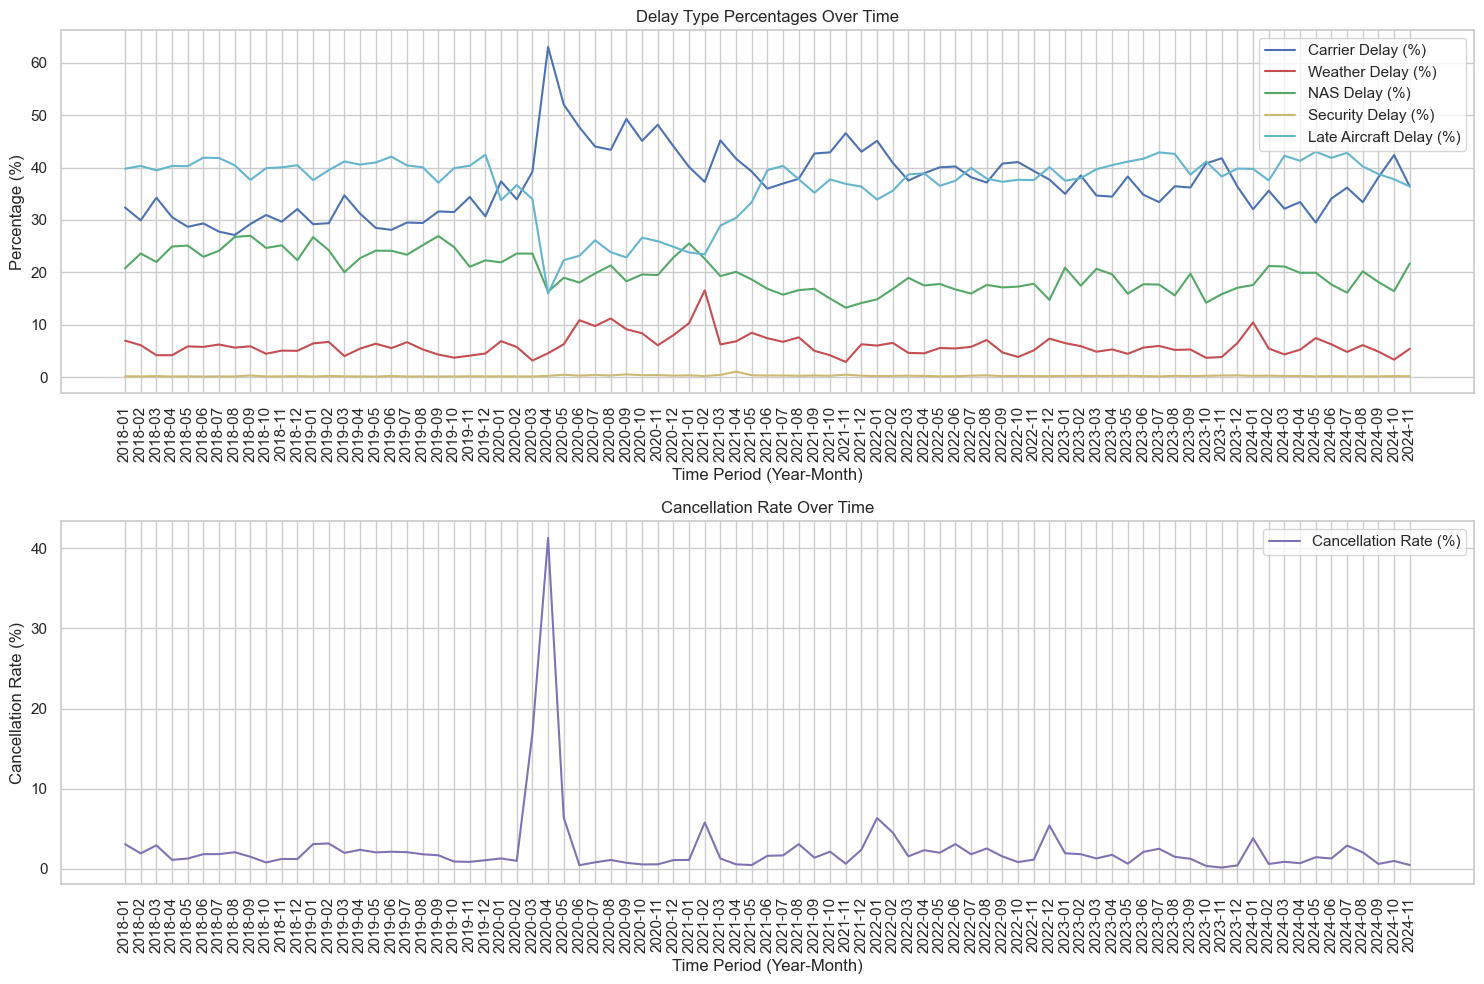

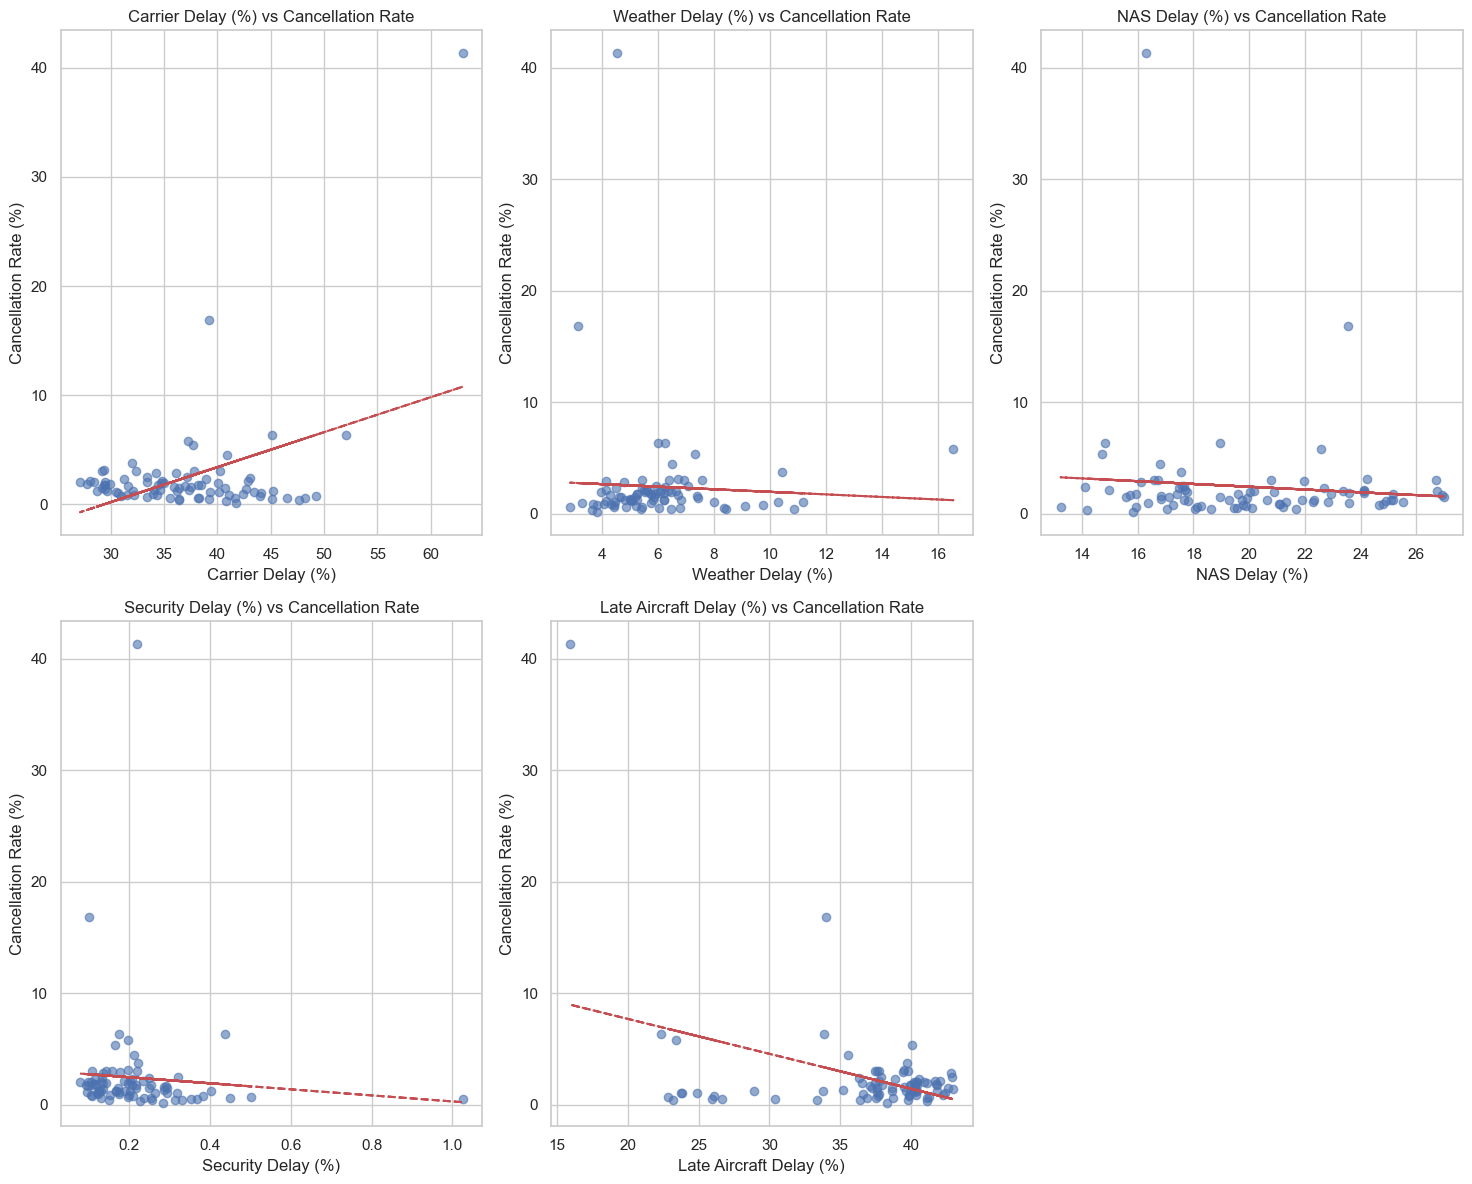

<Figure size 1500x1000 with 0 Axes>

In [45]:
import pandas as pd
import numpy as np
import psycopg2
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from scipy.stats import pearsonr, spearmanr
from decimal import Decimal

# Connect to the database
conn = psycopg2.connect(
    dbname=DB_NAME,
    user=DB_USER,
    password=DB_PASSWORD,
    host=DB_HOST,
    port=DB_PORT
)
cur = conn.cursor()

# Query 1: Analyze delay types and cancellations by month and year
query1 = """
SELECT 
    d.year,
    d.month,
    -- Calculate total delays of each type
    SUM(f.carrier_delay) AS total_carrier_delay,
    SUM(f.weather_delay) AS total_weather_delay,
    SUM(f.nas_delay) AS total_nas_delay,
    SUM(f.security_delay) AS total_security_delay,
    SUM(f.late_aircraft_delay) AS total_late_aircraft_delay,
    -- Calculate total delay minutes from all types
    SUM(COALESCE(f.carrier_delay, 0) + 
        COALESCE(f.weather_delay, 0) + 
        COALESCE(f.nas_delay, 0) + 
        COALESCE(f.security_delay, 0) + 
        COALESCE(f.late_aircraft_delay, 0)) AS total_delay_minutes,
    -- Count total flights and cancelled flights
    SUM(f.arr_flights) AS total_flights,
    SUM(f.arr_cancelled) AS cancelled_flights,
    -- Calculate cancellation rate
    CAST((SUM(f.arr_cancelled) / NULLIF(SUM(f.arr_flights), 0)) * 100 AS NUMERIC(10,4)) AS cancellation_rate
FROM 
    flight_delays_fact f
JOIN 
    date_dimension d ON f.date_key = d.date_key
GROUP BY 
    d.year, d.month
ORDER BY 
    d.year, d.month;
"""

# Query 2: Analyze delay types and cancellations for each carrier (airline)
query2 = """
SELECT 
    c.carrier_name,
    c.carrier,
    -- Calculate total delays of each type
    SUM(f.carrier_delay) AS total_carrier_delay,
    SUM(f.weather_delay) AS total_weather_delay,
    SUM(f.nas_delay) AS total_nas_delay,
    SUM(f.security_delay) AS total_security_delay,
    SUM(f.late_aircraft_delay) AS total_late_aircraft_delay,
    -- Calculate total delay minutes from all types
    SUM(COALESCE(f.carrier_delay, 0) + 
        COALESCE(f.weather_delay, 0) + 
        COALESCE(f.nas_delay, 0) + 
        COALESCE(f.security_delay, 0) + 
        COALESCE(f.late_aircraft_delay, 0)) AS total_delay_minutes,
    -- Count total flights and cancelled flights
    SUM(f.arr_flights) AS total_flights,
    SUM(f.arr_cancelled) AS cancelled_flights,
    -- Calculate cancellation rate
    CAST((SUM(f.arr_cancelled) / NULLIF(SUM(f.arr_flights), 0)) * 100 AS NUMERIC(10,4)) AS cancellation_rate
FROM 
    flight_delays_fact f
JOIN 
    airlines_dimension c ON f.carrier_key = c.carrier_key
GROUP BY 
    c.carrier_name, c.carrier
ORDER BY 
    c.carrier_name;
"""

# Query 3: Analyze delay types and cancellations for top airports
query3 = """
SELECT 
    a.airport_name,
    a.airport,
    -- Calculate total delays of each type
    SUM(f.carrier_delay) AS total_carrier_delay,
    SUM(f.weather_delay) AS total_weather_delay,
    SUM(f.nas_delay) AS total_nas_delay,
    SUM(f.security_delay) AS total_security_delay,
    SUM(f.late_aircraft_delay) AS total_late_aircraft_delay,
    -- Calculate total delay minutes from all types
    SUM(COALESCE(f.carrier_delay, 0) + 
        COALESCE(f.weather_delay, 0) + 
        COALESCE(f.nas_delay, 0) + 
        COALESCE(f.security_delay, 0) + 
        COALESCE(f.late_aircraft_delay, 0)) AS total_delay_minutes,
    -- Count total flights and cancelled flights
    SUM(f.arr_flights) AS total_flights,
    SUM(f.arr_cancelled) AS cancelled_flights,
    -- Calculate cancellation rate
    CAST((SUM(f.arr_cancelled) / NULLIF(SUM(f.arr_flights), 0)) * 100 AS NUMERIC(10,4)) AS cancellation_rate
FROM 
    flight_delays_fact f
JOIN 
    airports_dimension a ON f.airport_key = a.airport_key
GROUP BY 
    a.airport_name, a.airport
HAVING 
    SUM(f.arr_flights) > 1000  -- Only include major airports with significant traffic
ORDER BY 
    SUM(f.arr_flights) DESC
LIMIT 50;
"""

try:
    # Analysis 1: Time-based analysis of delay types and cancellations
    cur.execute(query1)
    results1 = cur.fetchall()
    
    columns = ['Year', 'Month', 'Total Carrier Delay', 'Total Weather Delay', 
               'Total NAS Delay', 'Total Security Delay', 'Total Late Aircraft Delay',
               'Total Delay Minutes', 'Total Flights', 'Cancelled Flights', 'Cancellation Rate (%)']
    
    df_time = pd.DataFrame(results1, columns=columns)
    
    # Convert all Decimal objects to float
    for col in df_time.columns:
        df_time[col] = df_time[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)
    
    # Calculate the percentage of each delay type
    df_time['Carrier Delay (%)'] = (df_time['Total Carrier Delay'] / df_time['Total Delay Minutes'] * 100).fillna(0)
    df_time['Weather Delay (%)'] = (df_time['Total Weather Delay'] / df_time['Total Delay Minutes'] * 100).fillna(0)
    df_time['NAS Delay (%)'] = (df_time['Total NAS Delay'] / df_time['Total Delay Minutes'] * 100).fillna(0)
    df_time['Security Delay (%)'] = (df_time['Total Security Delay'] / df_time['Total Delay Minutes'] * 100).fillna(0)
    df_time['Late Aircraft Delay (%)'] = (df_time['Total Late Aircraft Delay'] / df_time['Total Delay Minutes'] * 100).fillna(0)
    
    # Create a time period identifier (year-month)
    df_time['Period'] = df_time['Year'].astype(str) + '-' + df_time['Month'].astype(str).str.zfill(2)
    
    print("\nAnalysis 1: Time-Based Analysis of Delay Types and Cancellations")
    print("="*80)
    
    # Calculate correlation between each delay type percentage and cancellation rate
    corr_carrier = pearsonr(df_time['Carrier Delay (%)'], df_time['Cancellation Rate (%)'])
    corr_weather = pearsonr(df_time['Weather Delay (%)'], df_time['Cancellation Rate (%)'])
    corr_nas = pearsonr(df_time['NAS Delay (%)'], df_time['Cancellation Rate (%)'])
    corr_security = pearsonr(df_time['Security Delay (%)'], df_time['Cancellation Rate (%)'])
    corr_late = pearsonr(df_time['Late Aircraft Delay (%)'], df_time['Cancellation Rate (%)'])
    
    # Also calculate Spearman rank correlation (less sensitive to outliers)
    rank_corr_carrier = spearmanr(df_time['Carrier Delay (%)'], df_time['Cancellation Rate (%)'])
    rank_corr_weather = spearmanr(df_time['Weather Delay (%)'], df_time['Cancellation Rate (%)'])
    rank_corr_nas = spearmanr(df_time['NAS Delay (%)'], df_time['Cancellation Rate (%)'])
    rank_corr_security = spearmanr(df_time['Security Delay (%)'], df_time['Cancellation Rate (%)'])
    rank_corr_late = spearmanr(df_time['Late Aircraft Delay (%)'], df_time['Cancellation Rate (%)'])
    
    # Create correlation tables
    corr_data = [
        ['Carrier Delay (%)', f"{corr_carrier[0]:.4f}", f"{corr_carrier[1]:.4f}", f"{rank_corr_carrier[0]:.4f}", f"{rank_corr_carrier[1]:.4f}"],
        ['Weather Delay (%)', f"{corr_weather[0]:.4f}", f"{corr_weather[1]:.4f}", f"{rank_corr_weather[0]:.4f}", f"{rank_corr_weather[1]:.4f}"],
        ['NAS Delay (%)', f"{corr_nas[0]:.4f}", f"{corr_nas[1]:.4f}", f"{rank_corr_nas[0]:.4f}", f"{rank_corr_nas[1]:.4f}"],
        ['Security Delay (%)', f"{corr_security[0]:.4f}", f"{corr_security[1]:.4f}", f"{rank_corr_security[0]:.4f}", f"{rank_corr_security[1]:.4f}"],
        ['Late Aircraft Delay (%)', f"{corr_late[0]:.4f}", f"{corr_late[1]:.4f}", f"{rank_corr_late[0]:.4f}", f"{rank_corr_late[1]:.4f}"]
    ]
    
    corr_df = pd.DataFrame(corr_data, columns=['Delay Type', 'Pearson Correlation', 'P-value (Pearson)', 
                                              'Spearman Correlation', 'P-value (Spearman)'])
    
    print("\nCorrelation Between Delay Type Percentages and Cancellation Rate Over Time:")
    print(tabulate(corr_df, headers='keys', tablefmt='psql', showindex=False))
    
    # Create a time series chart of delay type percentages and cancellation rate
    plt.figure(figsize=(15, 10))
    
    # Plot delay type percentages
    plt.subplot(2, 1, 1)
    plt.plot(df_time['Period'], df_time['Carrier Delay (%)'], 'b-', label='Carrier Delay (%)')
    plt.plot(df_time['Period'], df_time['Weather Delay (%)'], 'r-', label='Weather Delay (%)')
    plt.plot(df_time['Period'], df_time['NAS Delay (%)'], 'g-', label='NAS Delay (%)')
    plt.plot(df_time['Period'], df_time['Security Delay (%)'], 'y-', label='Security Delay (%)')
    plt.plot(df_time['Period'], df_time['Late Aircraft Delay (%)'], 'c-', label='Late Aircraft Delay (%)')
    
    plt.title('Delay Type Percentages Over Time')
    plt.xlabel('Time Period (Year-Month)')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    
    # Plot cancellation rate
    plt.subplot(2, 1, 2)
    plt.plot(df_time['Period'], df_time['Cancellation Rate (%)'], 'm-', label='Cancellation Rate (%)')
    plt.title('Cancellation Rate Over Time')
    plt.xlabel('Time Period (Year-Month)')
    plt.ylabel('Cancellation Rate (%)')
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig('delay_cancellation_time_series.png')
    
    # Create a scatter plot matrix to show relationships
    plt.figure(figsize=(15, 12))
    
    delay_types = ['Carrier Delay (%)', 'Weather Delay (%)', 'NAS Delay (%)', 
                  'Security Delay (%)', 'Late Aircraft Delay (%)']
    
    for i, delay_type in enumerate(delay_types):
        plt.subplot(2, 3, i+1)
        plt.scatter(df_time[delay_type], df_time['Cancellation Rate (%)'], alpha=0.6)
        plt.xlabel(delay_type)
        plt.ylabel('Cancellation Rate (%)')
        plt.title(f'{delay_type} vs Cancellation Rate')
        plt.grid(True)
        
        # Add a trend line
        z = np.polyfit(df_time[delay_type], df_time['Cancellation Rate (%)'], 1)
        p = np.poly1d(z)
        plt.plot(df_time[delay_type], p(df_time[delay_type]), "r--")
    
    plt.tight_layout()
    plt.savefig('delay_cancellation_scatter.png')
    
    # Analysis 2: Carrier-based analysis
    cur.execute(query2)
    results2 = cur.fetchall()
    
    df_carrier = pd.DataFrame(results2, columns=columns[:2] + columns[2:])
    
    # Convert all Decimal objects to float
    for col in df_carrier.columns:
        df_carrier[col] = df_carrier[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)
    
    # Calculate the percentage of each delay type for each carrier
    df_carrier['Carrier Delay (%)'] = (df_carrier['Total Carrier Delay'] / df_carrier['Total Delay Minutes'] * 100).fillna(0)
    df_carrier['Weather Delay (%)'] = (df_carrier['Total Weather Delay'] / df_carrier['Total Delay Minutes'] * 100).fillna(0)
    df_carrier['NAS Delay (%)'] = (df_carrier['Total NAS Delay'] / df_carrier['Total Delay Minutes'] * 100).fillna(0)
    df_carrier['Security Delay (%)'] = (df_carrier['Total Security Delay'] / df_carrier['Total Delay Minutes'] * 100).fillna(0)
    df_carrier['Late Aircraft Delay (%)'] = (df_carrier['Total Late Aircraft Delay'] / df_carrier['Total Delay Minutes'] * 100).fillna(0)
    
    print("\nAnalysis 2: Carrier-Based Analysis of Delay Types and Cancellations")
    print("="*80)
    
    # Calculate correlation for carriers
    carrier_corr_carrier = pearsonr(df_carrier['Carrier Delay (%)'], df_carrier['Cancellation Rate (%)'])
    carrier_corr_weather = pearsonr(df_carrier['Weather Delay (%)'], df_carrier['Cancellation Rate (%)'])
    carrier_corr_nas = pearsonr(df_carrier['NAS Delay (%)'], df_carrier['Cancellation Rate (%)'])
    carrier_corr_security = pearsonr(df_carrier['Security Delay (%)'], df_carrier['Cancellation Rate (%)'])
    carrier_corr_late = pearsonr(df_carrier['Late Aircraft Delay (%)'], df_carrier['Cancellation Rate (%)'])
    
    # Create carrier correlation table
    carrier_corr_data = [
        ['Carrier Delay (%)', f"{carrier_corr_carrier[0]:.4f}", f"{carrier_corr_carrier[1]:.4f}"],
        ['Weather Delay (%)', f"{carrier_corr_weather[0]:.4f}", f"{carrier_corr_weather[1]:.4f}"],
        ['NAS Delay (%)', f"{carrier_corr_nas[0]:.4f}", f"{carrier_corr_nas[1]:.4f}"],
        ['Security Delay (%)', f"{carrier_corr_security[0]:.4f}", f"{carrier_corr_security[1]:.4f}"],
        ['Late Aircraft Delay (%)', f"{carrier_corr_late[0]:.4f}", f"{carrier_corr_late[1]:.4f}"]
    ]
    
    carrier_corr_df = pd.DataFrame(carrier_corr_data, columns=['Delay Type', 'Correlation', 'P-value'])
    
    print("\nCorrelation Between Delay Type Percentages and Cancellation Rate Across Carriers:")
    print(tabulate(carrier_corr_df, headers='keys', tablefmt='psql', showindex=False))
    
    # Create a stacked bar chart showing delay type distribution for each carrier
    plt.figure(figsize=(15, 10))
    
    # Prepare data for stacked bar
    carriers = df_carrier['carrier'].tolist()
    carrier_delays = [df_carrier['Carrier Delay (%)'].tolist(),
                     df_carrier['Weather Delay (%)'].tolist(),
                     df_carrier['NAS Delay (%)'].tolist(),
                     df_carrier['Security Delay (%)'].tolist(),
                     df_carrier['Late Aircraft Delay (%)'].tolist()]
    
    colors = ['b', 'r', 'g', 'y', 'c']
    labels = ['Carrier Delay', 'Weather Delay', 'NAS Delay', 'Security Delay', 'Late Aircraft Delay']
    
    # Plot stacked bar chart
    plt.subplot(2, 1, 1)
    bottom = np.zeros(len(carriers))
    
    for i, delay_data in enumerate(carrier_delays):
        plt.bar(carriers, delay_data, bottom=bottom, label=labels[i], color=colors[i], alpha=0.7)
        bottom += np.array(delay_data)
    
    plt.title('Delay Type Distribution by Carrier')
    plt.xlabel('Carrier')
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=90)
    plt.legend(loc='upper right')
    
    # Plot cancellation rate by carrier
    plt.subplot(2, 1, 2)
    plt.bar(df_carrier['carrier'], df_carrier['Cancellation Rate (%)'], color='m', alpha=0.7)
    plt.title('Cancellation Rate by Carrier')
    plt.xlabel('Carrier')
    plt.ylabel('Cancellation Rate (%)')
    plt.xticks(rotation=90)
    
    plt.tight_layout()
    plt.savefig('delay_cancellation_by_carrier.png')
    
    # Analysis 3: Airport-based analysis
    cur.execute(query3)
    results3 = cur.fetchall()
    
    df_airport = pd.DataFrame(results3, columns=columns[:2] + columns[2:])
    
    # Convert all Decimal objects to float
    for col in df_airport.columns:
        df_airport[col] = df_airport[col].apply(lambda x: float(x) if isinstance(x, Decimal) else x)
    
    # Calculate the percentage of each delay type for each airport
    df_airport['Carrier Delay (%)'] = (df_airport['Total Carrier Delay'] / df_airport['Total Delay Minutes'] * 100).fillna(0)
    df_airport['Weather Delay (%)'] = (df_airport['Total Weather Delay'] / df_airport['Total Delay Minutes'] * 100).fillna(0)
    df_airport['NAS Delay (%)'] = (df_airport['Total NAS Delay'] / df_airport['Total Delay Minutes'] * 100).fillna(0)
    df_airport['Security Delay (%)'] = (df_airport['Total Security Delay'] / df_airport['Total Delay Minutes'] * 100).fillna(0)
    df_airport['Late Aircraft Delay (%)'] = (df_airport['Total Late Aircraft Delay'] / df_airport['Total Delay Minutes'] * 100).fillna(0)
    
    print("\nAnalysis 3: Airport-Based Analysis of Delay Types and Cancellations")
    print("="*80)
    
    # Calculate correlation for airports
    airport_corr_carrier = pearsonr(df_airport['Carrier Delay (%)'], df_airport['Cancellation Rate (%)'])
    airport_corr_weather = pearsonr(df_airport['Weather Delay (%)'], df_airport['Cancellation Rate (%)'])
    airport_corr_nas = pearsonr(df_airport['NAS Delay (%)'], df_airport['Cancellation Rate (%)'])
    airport_corr_security = pearsonr(df_airport['Security Delay (%)'], df_airport['Cancellation Rate (%)'])
    airport_corr_late = pearsonr(df_airport['Late Aircraft Delay (%)'], df_airport['Cancellation Rate (%)'])
    
    # Create airport correlation table
    airport_corr_data = [
        ['Carrier Delay (%)', f"{airport_corr_carrier[0]:.4f}", f"{airport_corr_carrier[1]:.4f}"],
        ['Weather Delay (%)', f"{airport_corr_weather[0]:.4f}", f"{airport_corr_weather[1]:.4f}"],
        ['NAS Delay (%)', f"{airport_corr_nas[0]:.4f}", f"{airport_corr_nas[1]:.4f}"],
        ['Security Delay (%)', f"{airport_corr_security[0]:.4f}", f"{airport_corr_security[1]:.4f}"],
        ['Late Aircraft Delay (%)', f"{airport_corr_late[0]:.4f}", f"{airport_corr_late[1]:.4f}"]
    ]
    
    airport_corr_df = pd.DataFrame(airport_corr_data, columns=['Delay Type', 'Correlation', 'P-value'])
    
    print("\nCorrelation Between Delay Type Percentages and Cancellation Rate Across Airports:")
    print(tabulate(airport_corr_df, headers='keys', tablefmt='psql', showindex=False))
    
    # Create a heatmap of top 15 airports showing delay type percentages and cancellation rate
    plt.figure(figsize=(14, 10))
    
    # Select top 15 airports by total flights
    top_airports = df_airport.sort_values('Total Flights', ascending=False).head(15)
    
    # Prepare heatmap data
    heatmap_data = top_airports[['airport', 'Carrier Delay (%)', 'Weather Delay (%)', 
                               'NAS Delay (%)', 'Security Delay (%)', 
                               'Late Aircraft Delay (%)', 'Cancellation Rate (%)']].set_index('airport')
    
    # Plot heatmap
    sns.heatmap(heatmap_data, annot=True, fmt='.1f', cmap='YlGnBu', linewidths=.5)
    plt.title('Delay Type Percentages and Cancellation Rate for Top 15 Airports')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('delay_cancellation_airport_heatmap.png')
    
    # Additional analysis: Investigate which delay type is the strongest predictor of cancellations
    # Create a summary of all correlations across time, carriers, and airports
    summary_data = [
        ['Time Series Analysis', f"{corr_carrier[0]:.4f}", f"{corr_weather[0]:.4f}", 
         f"{corr_nas[0]:.4f}", f"{corr_security[0]:.4f}", f"{corr_late[0]:.4f}"],
        ['Carrier Analysis', f"{carrier_corr_carrier[0]:.4f}", f"{carrier_corr_weather[0]:.4f}", 
         f"{carrier_corr_nas[0]:.4f}", f"{carrier_corr_security[0]:.4f}", f"{carrier_corr_late[0]:.4f}"],
        ['Airport Analysis', f"{airport_corr_carrier[0]:.4f}", f"{airport_corr_weather[0]:.4f}", 
         f"{airport_corr_nas[0]:.4f}", f"{airport_corr_security[0]:.4f}", f"{airport_corr_late[0]:.4f}"]
    ]
    
    summary_df = pd.DataFrame(summary_data, 
                             columns=['Analysis Type', 'Carrier Delay', 'Weather Delay', 
                                     'NAS Delay', 'Security Delay', 'Late Aircraft Delay'])
    
    print("\nSummary of Correlations Between Delay Type Percentages and Cancellation Rate:")
    print(tabulate(summary_df, headers='keys', tablefmt='psql', showindex=False))
    
    # Create a summary bar chart
    plt.figure(figsize=(12, 8))
    
    # Prepare data for grouped bar chart
    x = np.arange(5)  # 5 delay types
    width = 0.25
    
    plt.bar(x - width, [corr_carrier[0], corr_weather[0], corr_nas[0], corr_security[0], corr_late[0]], 
           width=width, label='Time Series', color='blue', alpha=0.7)
    
    plt.bar(x, [carrier_corr_carrier[0], carrier_corr_weather[0], carrier_corr_nas[0], 
                carrier_corr_security[0], carrier_corr_late[0]], 
           width=width, label='Carrier', color='green', alpha=0.7)
    
    plt.bar(x + width, [airport_corr_carrier[0], airport_corr_weather[0], airport_corr_nas[0], 
                       airport_corr_security[0], airport_corr_late[0]], 
           width=width, label='Airport', color='red', alpha=0.7)
    
    plt.xlabel('Delay Type')
    plt.ylabel('Correlation with Cancellation Rate')
    plt.title('Correlation Between Delay Types and Cancellation Rate Across Different Analyses')
    plt.xticks(x, ['Carrier', 'Weather', 'NAS', 'Security', 'Late Aircraft'])
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    
    # Add a horizontal line at y=0
    plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('delay_cancellation_correlation_summary.png')
    
    print("\nAll analyses complete. Charts saved to:")
    print("  - delay_cancellation_time_series.png")
    print("  - delay_cancellation_scatter.png")
    print("  - delay_cancellation_by_carrier.png")
    print("  - delay_cancellation_airport_heatmap.png")
    print("  - delay_cancellation_correlation_summary.png")
    
except Exception as e:
    print(f"Error analyzing delay-cancellation correlation: {e}")
    import traceback
    traceback.print_exc()
finally:
    # Close cursor and connection
    cur.close()
    conn.close()